# LDA

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from scipy import sparse
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jueju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
sparse_matrix = pd.read_csv('test_new_stem.csv', header=None)

In [5]:
nn = pd.read_csv('df_doc_topic_new_stemming.csv')

In [6]:
nn

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2
...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3


In [7]:
# Import Dataset
df = pd.read_csv('Twitter_mani.csv')
del df['Unnamed: 0']
print(df.screen_name.unique())
df.head()

['UMichFootball' 'vegancook101' 'PPFA' 'breakingweather']


,user_id,user_id_new,screen_name,text
0,27902825,2,UMichFootball,👇 https://t.co/swtsZWWaJe
1,27902825,2,UMichFootball,Leave it all on the field! @UMichFootball! Bes...
2,27902825,2,UMichFootball,There’s no time to look backwards… only ahead!...
3,27902825,2,UMichFootball,2️⃣4️⃣:0️⃣0️⃣:0️⃣0️⃣ ⏳ https://t.co/eM3yUXJXaq
4,27902825,2,UMichFootball,It’s called “The Game’ for a reason. \r\n\r\n#...


In [8]:
# Convert to lowercase and convert to list
data = df.text.str.lower().values.tolist()
print(data[4:5])
# Remove Emails
data = [re.sub('@', '', sent) for sent in data]

# Remove hashtages
data = [re.sub('#', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
#data = [re.sub("\'", "", sent) for sent in data]

# Remove url
data = [re.sub(r'http\S+', '', sent) for sent in data]

# Remove Unicode
#data = [re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', sent)  for sent in data]

# Remove numbers, special characters, multiple exclamation mark, multiple full stop and multiple commas
#texts= ''.join([i for i in textsif not i.isdigit()])
#data = [re.sub(r"(\!)\1+", ' ', sent)  for sent in data]
#data = [re.sub(r"(\?)\1+", ' ', sent)  for sent in data]
#data = [re.sub(r"(\.)\1+", '.', sent)  for sent in data]

 
pprint(data[4:5])

['it’s called “the game’ for a reason. \r\n\r\n#goblue | #beatosu https://t.co/qa6xzs3typ']
['it’s called “the game’ for a reason. goblue | beatosu ']


In [9]:
data

['👇 ',
 'leave it all on the field! umichfootball! best rivalry in college football!! goblue | beatosu ',
 'there’s no time to look backwards… only ahead! hyped to watch the umichfootball squad ball out! goblue | beatosu ',
 '2️⃣4️⃣:0️⃣0️⃣:0️⃣0️⃣ ⏳ ',
 'it’s called “the game’ for a reason. goblue | beatosu ',
 'on saturday, our seniors will play their final game at the big house. we 💙 our seniors! goblue | beatosu ',
 '〽️ ',
 'the glasgow decade with umichfootball is just about complete. story »  goblue | beatosu',
 'can’t wait to watch the umichfootball squad ball out on saturday! goblue | beatosu ',
 'congrats to all of the umichfootball seniors on a great career! ball out on saturday boys! goblue | beatosu ',
 'two more sleeps. goblue | beatosu ',
 'our interactive digital guide will get you all ready for michigan vs. ohio state! be sure to check out the q&amp;a with sheapatterson_1! digital guide »  goblue | beatosu 〽️ ',
 'seize your opportunity umichfootball! we are all behind yo

In [10]:
import numpy as np
# used in pre-processing function
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
# used for creating word matrix w
from sklearn.feature_extraction.text import CountVectorizer
import math


### define functions needed for makeMatrices function
## pre-processing: stem, remove URLs and stop words
def preProcessingFcn(tweet, 
    removeNumbers=True, removePunctuation=True):
    
    tweet = re.sub(r"\\n", " ", tweet)
    tweet = re.sub(r"&amp", " ", tweet)

    if removeNumbers==True:
        tweet=  ''.join(i for i in tweet if not i.isdigit())
    if removePunctuation==True:
        tweet = re.sub(r"[,.;@#?!&$]+\ *", " ", tweet)
  
    return tweet

after_basis_preprocess = [preProcessingFcn(tweet) for tweet in data]

In [11]:
data = after_basis_preprocess

In [12]:
data

['👇 ',
 'leave it all on the field umichfootball best rivalry in college football goblue | beatosu ',
 'there’s no time to look backwards… only ahead hyped to watch the umichfootball squad ball out goblue | beatosu ',
 '️⃣️⃣:️⃣️⃣:️⃣️⃣ ⏳ ',
 'it’s called “the game’ for a reason goblue | beatosu ',
 'on saturday our seniors will play their final game at the big house we 💙 our seniors goblue | beatosu ',
 '〽️ ',
 'the glasgow decade with umichfootball is just about complete story »  goblue | beatosu',
 'can’t wait to watch the umichfootball squad ball out on saturday goblue | beatosu ',
 'congrats to all of the umichfootball seniors on a great career ball out on saturday boys goblue | beatosu ',
 'two more sleeps goblue | beatosu ',
 'our interactive digital guide will get you all ready for michigan vs ohio state be sure to check out the q  a with sheapatterson_ digital guide »  goblue | beatosu 〽️ ',
 'seize your opportunity umichfootball we are all behind you goblue | beatosu ',
 "umich

In [13]:
# simple_preprocess() tokenies the text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])
print(len(data_words))

[[], ['leave', 'it', 'all', 'on', 'the', 'field', 'umichfootball', 'best', 'rivalry', 'in', 'college', 'football', 'goblue', 'beatosu'], ['there', 'no', 'time', 'to', 'look', 'backwards', 'only', 'ahead', 'hyped', 'to', 'watch', 'the', 'umichfootball', 'squad', 'ball', 'out', 'goblue', 'beatosu']]
12780


In [14]:
# NLTK Stop words
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [15]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts):#, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Unigrams
data_words_unigrams = data_words_nostops


In [17]:
data_words_unigrams

[[],
 ['leave',
  'field',
  'umichfootball',
  'best',
  'rivalry',
  'college',
  'football',
  'goblue',
  'beatosu'],
 ['time',
  'look',
  'backwards',
  'ahead',
  'hyped',
  'watch',
  'umichfootball',
  'squad',
  'ball',
  'goblue',
  'beatosu'],
 [],
 ['called', 'game', 'reason', 'goblue', 'beatosu'],
 ['saturday',
  'seniors',
  'play',
  'final',
  'game',
  'big',
  'house',
  'seniors',
  'goblue',
  'beatosu'],
 [],
 ['glasgow',
  'decade',
  'umichfootball',
  'complete',
  'story',
  'goblue',
  'beatosu'],
 ['wait',
  'watch',
  'umichfootball',
  'squad',
  'ball',
  'saturday',
  'goblue',
  'beatosu'],
 ['congrats',
  'umichfootball',
  'seniors',
  'great',
  'career',
  'ball',
  'saturday',
  'boys',
  'goblue',
  'beatosu'],
 ['two', 'sleeps', 'goblue', 'beatosu'],
 ['interactive',
  'digital',
  'guide',
  'get',
  'ready',
  'michigan',
  'vs',
  'ohio',
  'state',
  'sure',
  'check',
  'sheapatterson_',
  'digital',
  'guide',
  'goblue',
  'beatosu'],
 ['s

# Lemmatization

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')#, disable=['parser', 'ner'])

# Do lemmatization 
#keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_unigrams) #allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [19]:
data_lemmatized

[[],
 ['leave',
  'field',
  'umichfootball',
  'good',
  'rivalry',
  'college',
  'football',
  'goblue',
  'beatosu'],
 ['time',
  'look',
  'backwards',
  'ahead',
  'hype',
  'watch',
  'umichfootball',
  'squad',
  'ball',
  'goblue',
  'beatosu'],
 [],
 ['call', 'game', 'reason', 'goblue', 'beatosu'],
 ['saturday',
  'senior',
  'play',
  'final',
  'game',
  'big',
  'house',
  'senior',
  'goblue',
  'beatosu'],
 [],
 ['glasgow',
  'decade',
  'umichfootball',
  'complete',
  'story',
  'goblue',
  'beatosu'],
 ['wait',
  'watch',
  'umichfootball',
  'squad',
  'ball',
  'saturday',
  'goblue',
  'beatosu'],
 ['congrat',
  'umichfootball',
  'senior',
  'great',
  'career',
  'ball',
  'saturday',
  'boys',
  'goblue',
  'beatosu'],
 ['two', 'sleep', 'goblue', 'beatosu'],
 ['interactive',
  'digital',
  'guide',
  'get',
  'ready',
  'michigan',
  'vs',
  'ohio',
  'state',
  'sure',
  'check',
  'sheapatterson',
  '_',
  'digital',
  'guide',
  'goblue',
  'beatosu'],
 ['sei

In [20]:
better_visualize = []
for i in data_lemmatized:
    tweet = ' '.join(i)
    better_visualize.append(tweet)

In [21]:
pd.DataFrame(better_visualize).head(20)

,0
0,
1,leave field umichfootball good rivalry college...
2,time look backwards ahead hype watch umichfoot...
3,
4,call game reason goblue beatosu
5,saturday senior play final game big house seni...
6,
7,glasgow decade umichfootball complete story go...
8,wait watch umichfootball squad ball saturday g...
9,congrat umichfootball senior great career ball...


# Stemming

In [22]:
data = []
for i in data_words_unigrams:
    tweet = ' '.join(i)
    data.append(tweet)

In [23]:
data

['',
 'leave field umichfootball best rivalry college football goblue beatosu',
 'time look backwards ahead hyped watch umichfootball squad ball goblue beatosu',
 '',
 'called game reason goblue beatosu',
 'saturday seniors play final game big house seniors goblue beatosu',
 '',
 'glasgow decade umichfootball complete story goblue beatosu',
 'wait watch umichfootball squad ball saturday goblue beatosu',
 'congrats umichfootball seniors great career ball saturday boys goblue beatosu',
 'two sleeps goblue beatosu',
 'interactive digital guide get ready michigan vs ohio state sure check sheapatterson_ digital guide goblue beatosu',
 'seize opportunity umichfootball behind goblue beatosu',
 'umichbball elijbrooks let go',
 'happy thanksgiving pro bowl social voting officially starts today til december fans tweet vote pro bowl options probowlvote devin bush probowlvote devinbush probowlvote',
 'wait watch umichfootball saturday greatest rivalry sports goblue beatosu',
 'glasgow decade compl

In [24]:
## packages needed for makeMatrices function
# used for many things
import numpy as np
# used in pre-processing function
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
# used for creating word matrix w
from sklearn.feature_extraction.text import CountVectorizer
import math


### define functions needed for makeMatrices function
## pre-processing: stem, remove URLs and stop words
def preProcessingFcn(tweet, stem=True):
    ps = PorterStemmer()

    if stem==True:
        tweet = ' '.join([ps.stem(word) for word in tweet.split()])
    return tweet

data_lemmatized = [preProcessingFcn(tweet) for tweet in data]

In [25]:
data_lemmatized1 = []
for i in data_lemmatized:
    alist = i.split()
    data_lemmatized1.append(alist)

In [26]:
data_lemmatized = data_lemmatized1
data_lemmatized

[[],
 ['leav',
  'field',
  'umichfootbal',
  'best',
  'rivalri',
  'colleg',
  'footbal',
  'goblu',
  'beatosu'],
 ['time',
  'look',
  'backward',
  'ahead',
  'hype',
  'watch',
  'umichfootbal',
  'squad',
  'ball',
  'goblu',
  'beatosu'],
 [],
 ['call', 'game', 'reason', 'goblu', 'beatosu'],
 ['saturday',
  'senior',
  'play',
  'final',
  'game',
  'big',
  'hous',
  'senior',
  'goblu',
  'beatosu'],
 [],
 ['glasgow', 'decad', 'umichfootbal', 'complet', 'stori', 'goblu', 'beatosu'],
 ['wait',
  'watch',
  'umichfootbal',
  'squad',
  'ball',
  'saturday',
  'goblu',
  'beatosu'],
 ['congrat',
  'umichfootbal',
  'senior',
  'great',
  'career',
  'ball',
  'saturday',
  'boy',
  'goblu',
  'beatosu'],
 ['two', 'sleep', 'goblu', 'beatosu'],
 ['interact',
  'digit',
  'guid',
  'get',
  'readi',
  'michigan',
  'vs',
  'ohio',
  'state',
  'sure',
  'check',
  'sheapatterson_',
  'digit',
  'guid',
  'goblu',
  'beatosu'],
 ['seiz', 'opportun', 'umichfootbal', 'behind', 'goblu'

# Then

In [27]:
# Count unique words
merged = list(itertools.chain.from_iterable(data_lemmatized))
print(len(merged))
print(len(set(merged)))

# Identify words that appears at least 20 times
c = Counter(merged)
a = list(Counter({k: c for k, c in c.items() if c >= 20}).keys())

141434
10241


In [28]:
# Select words that appears at least 20 times
for i,value in enumerate(data_lemmatized):
    data_lemmatized[i] = [i for i in value if i in a] 

In [29]:
# Check
merged = list(itertools.chain.from_iterable(data_lemmatized))
len(set(merged))

1321

In [30]:
# Get the index of the doc that are deleted
empty_idx = []

for i, value in enumerate(data_lemmatized):
    if any(value) == False:
        empty_idx.append(i)
len(empty_idx)

341

In [31]:
# Delete empty elements
data_lemmatized2 = list(filter(None, data_lemmatized))
print(len(data_lemmatized2))

#the percentage of samples discarded
(12780 - 12439)/12780

12439


0.026682316118935838

In [32]:
(12780 - 12439)/12780

0.026682316118935838

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts = data_lemmatized2

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:3])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(0, 1), (5, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(0, 1), (5, 1), (13, 1), (14, 1)]]


In [34]:
for cp in corpus[:3]:
    print(cp)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(0, 1), (5, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]
[(0, 1), (5, 1), (13, 1), (14, 1)]


In [35]:
id2word.items()

ItemsView(<gensim.corpora.dictionary.Dictionary object at 0x0000025249807F88>)

In [36]:
id2word[0]

'beatosu'

In [37]:
word_metadata = []

for i,j in enumerate(id2word):
    a = id2word[i]
    word_metadata.append(a)

In [38]:
len(word_metadata)

1321

In [39]:
word_metadata_new = {'K': list(range(0, 1321)),
        'word': word_metadata,
        }

In [40]:
word_metadata_new = pd.DataFrame(word_metadata_new)

In [41]:
word_metadata_new

,K,word
0,0,beatosu
1,1,best
2,2,colleg
3,3,field
4,4,footbal
...,...,...
1316,1316,karen
1317,1317,bahama
1318,1318,imelda
1319,1319,dorian


In [42]:
word_metadata_new.to_csv('word_metadata_new.csv')

In [43]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[('beatosu', 1),
  ('best', 1),
  ('colleg', 1),
  ('field', 1),
  ('footbal', 1),
  ('goblu', 1),
  ('leav', 1),
  ('umichfootbal', 1)],
 [('beatosu', 1),
  ('goblu', 1),
  ('umichfootbal', 1),
  ('ahead', 1),
  ('ball', 1),
  ('look', 1),
  ('time', 1),
  ('watch', 1)],
 [('beatosu', 1), ('goblu', 1), ('call', 1), ('game', 1)]]

In [44]:
# Check
merged = list(itertools.chain.from_iterable(data_lemmatized2))
len(set(merged))

1321

In [45]:
lda_model =  gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = 4, random_state = 88)

In [61]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.022*"storm" + 0.019*"week" + 0.017*"tropic" + 0.017*"across" + 0.014*"thunderstorm" + 0.013*"flood" + 0.012*"heat" + 0.012*"weekend" + 0.011*"state" + 0.011*"weather"


Topic: 1 
Words: 0.027*"health" + 0.021*"care" + 0.018*"plan" + 0.018*"ppfa" + 0.017*"peopl" + 0.012*"parenthood" + 0.012*"get" + 0.012*"need" + 0.011*"abort" + 0.011*"women"


Topic: 2 
Words: 0.055*"goblu" + 0.031*"month" + 0.022*"michigan" + 0.016*"one" + 0.016*"year" + 0.016*"first" + 0.013*"night" + 0.011*"game" + 0.011*"day" + 0.011*"meteor"


Topic: 3 
Words: 0.082*"vegan" + 0.046*"wave" + 0.028*"recip" + 0.023*"summer" + 0.021*"made" + 0.015*"free" + 0.014*"bake" + 0.013*"make" + 0.013*"easi" + 0.012*"tofu"




In [62]:
df_new = df_new.reset_index(drop=True)

NameError: name 'df_new' is not defined

In [64]:
#Get the topic distribution for the given document, #doc in bow format
df_doc_topic = pd.DataFrame(columns = ['Doc_ID', 'Dominant_Topic', 'Prob_Per_Topic', 'Keywords', 'Doc_Text'])
for i in range(len(corpus)):
  a = lda_model.get_document_topics(corpus[i])
  a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
  topic_wp = lda_model.show_topic(a[0][0]) #show top 10 words byb default
  keywords = [w for (w,p) in topic_wp]
  row = [i, a[0][0], a[0][1], keywords, df_new['text'][i]]
  df_doc_topic.loc[i] = row

NameError: name 'df_new' is not defined

In [65]:
Correct_target = pd.DataFrame(df[["screen_name", "user_id_new"]])
Correct_target = Correct_target.drop(Correct_target.index[empty_idx]).reset_index(drop=True)
df_doc_topic = df_doc_topic.reset_index(drop=True)
df_compare = pd.concat([df_doc_topic, Correct_target.reindex(df_doc_topic.index)], axis=1)

In [66]:
df_compare

,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new


In [220]:
df_compare

,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new
0,0,2,0.795327,"[goblu, month, michigan, one, year, first, nig...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2
1,1,2,0.915653,"[goblu, month, michigan, one, year, first, nig...",There’s no time to look backwards… only ahead!...,UMichFootball,2
2,2,2,0.665839,"[goblu, month, michigan, one, year, first, nig...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2
3,3,2,0.931682,"[goblu, month, michigan, one, year, first, nig...","On Saturday, our seniors will play their final...",UMichFootball,2
4,4,2,0.891148,"[goblu, month, michigan, one, year, first, nig...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2
...,...,...,...,...,...,...,...
12434,12434,0,0.810503,"[storm, week, tropic, across, thunderstorm, fl...",A flash flood emergency is in effect for south...,breakingweather,3
12435,12435,0,0.658410,"[storm, week, tropic, across, thunderstorm, fl...","Now that Barry, the first hurricane to make U....",breakingweather,3
12436,12436,0,0.872414,"[storm, week, tropic, across, thunderstorm, fl...","Showers and locally heavy, drenching thunderst...",breakingweather,3
12437,12437,0,0.886538,"[storm, week, tropic, across, thunderstorm, fl...",While Monday felt like a typical summer day in...,breakingweather,3


In [424]:
 #df_doc_topic.to_csv('df_doc_topic.csv')

In [425]:
#df_doc_topic.to_csv('df_doc_topic.csv')
#df_compare.to_csv('df_doc_topic_new_stemming.csv')
#df_doc_topic.to_csv('df_doc_topic_new_lemmatization.csv')

In [67]:
df_compare = pd.read_csv('df_doc_topic_new_stemming.csv')

In [68]:
df_compare

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2
...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3


In [426]:
#Correct_target.to_csv('Correct_target.csv')
#Correct_target.to_csv('Correct_target_new_stemming.csv')
#Correct_target.to_csv('Correct_target_new_lemmatiztion.csv')

In [61]:
True_Label = list(df_compare["user_id_new"])

In [62]:
len(True_Label)

12439

In [63]:
#savetxt('True_Label_new_stemming.csv', True_Label, delimiter=',') # True_label previously
#savetxt('True_Label_new_lemmatization.csv', True_Label, delimiter=',') # True_label previously

In [64]:
df_compare

,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new
0,0,2,0.795327,"[goblu, month, michigan, one, year, first, nig...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2
1,1,2,0.915653,"[goblu, month, michigan, one, year, first, nig...",There’s no time to look backwards… only ahead!...,UMichFootball,2
2,2,2,0.665839,"[goblu, month, michigan, one, year, first, nig...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2
3,3,2,0.931682,"[goblu, month, michigan, one, year, first, nig...","On Saturday, our seniors will play their final...",UMichFootball,2
4,4,2,0.891148,"[goblu, month, michigan, one, year, first, nig...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2
...,...,...,...,...,...,...,...
12434,12434,0,0.810503,"[storm, week, tropic, across, thunderstorm, fl...",A flash flood emergency is in effect for south...,breakingweather,3
12435,12435,0,0.658410,"[storm, week, tropic, across, thunderstorm, fl...","Now that Barry, the first hurricane to make U....",breakingweather,3
12436,12436,0,0.872414,"[storm, week, tropic, across, thunderstorm, fl...","Showers and locally heavy, drenching thunderst...",breakingweather,3
12437,12437,0,0.886538,"[storm, week, tropic, across, thunderstorm, fl...",While Monday felt like a typical summer day in...,breakingweather,3


In [80]:
df_compare["tokenize"] = data_lemmatized2

In [82]:
df_compare

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new,Spec_svd,Spec_arpack,tokenize
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2,1,1,"[leav, field, umichfootbal, best, colleg, foot..."
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2,1,1,"[time, look, ahead, watch, umichfootbal, ball,..."
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2,1,1,"[call, game, goblu, beatosu]"
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2,1,1,"[saturday, senior, play, final, game, big, hou..."
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2,1,1,"[decad, umichfootbal, complet, stori, goblu, b..."
...,...,...,...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3,1,1,"[flash, flood, emerg, effect, southwestern, la..."
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3,1,1,"[first, hurrican, make, landfal, year, come, s..."
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3,1,1,"[shower, local, heavi, drench, thunderstorm, a..."
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3,1,1,"[monday, felt, like, typic, summer, day, north..."


In [67]:
#df_compare.to_csv('token.csv')

# ITCC

In [323]:
model = CoclustInfo(n_row_clusters=4, n_col_clusters=4,
                    n_init=4, random_state=88)
model.fit(b)
n = list(model.row_labels_)

In [324]:
n

[2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,


In [69]:
df_new = df_compare
df_new["ITCC_results"] = n

In [70]:
df_new

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new,ITCC_results
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2,1
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2,1
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2,1
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2,1
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2,1
...,...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3,1
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3,1
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3,1
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3,1


In [331]:
#Cluster 2
a_2 = list(df_new[df_new["ITCC_results"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["ITCC_results"] == 0]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["ITCC_results"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["ITCC_results"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['vegan', 'goblu', 'recip', 'tofu', 'chocol', 'michigan', 'easi', 'potato', 'made', 'bean']
['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flood']
['goblu', 'michigan', 'vegan', 'umichfootbal', 'day', 'game', 'make', 'time', 'first', 'one']
['health', 'care', 'ppfa', 'plan', 'parenthood', 'peopl', 'abort', 'women', 'get', 'thank']


In [332]:
data = {'Cluster_0': Cluster_0,
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,storm,goblu,vegan,health
1,week,michigan,goblu,care
2,across,vegan,recip,ppfa
3,tropic,umichfootbal,tofu,plan
4,wind,day,chocol,parenthood
5,rain,game,michigan,peopl
6,state,make,easi,abort
7,weather,time,potato,women
8,unit,first,made,get
9,flood,one,bean,thank


# BBAC

In [333]:
BBAC =pd.read_csv("BBAC_results_stemming.csv")

In [334]:
BBAC

,Unnamed: 0,x,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1,1,1,4,2,2,7,1,2,2,11,11,4,9,8,13,7,12,6,14
1,2,2,1,4,2,6,1,1,2,5,11,10,4,8,8,13,7,12,5,20
2,3,3,1,4,2,2,7,1,2,2,11,10,4,8,8,13,7,12,5,20
3,4,4,1,4,2,2,7,1,2,5,11,11,4,8,8,12,7,12,5,20
4,5,5,1,4,2,2,1,1,2,2,11,10,4,8,8,13,7,12,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,12435,12435,3,1,4,3,3,7,3,9,1,9,8,1,3,10,8,14,12,1
12435,12436,12436,3,1,4,5,4,4,9,6,4,5,1,10,15,9,10,6,14,13
12436,12437,12437,3,1,4,3,3,4,9,10,10,9,8,12,9,3,8,6,4,2
12437,12438,12438,3,1,4,3,4,4,9,10,7,3,8,12,9,10,10,6,13,7


In [335]:
df_new["BBAC_results"]=BBAC["4"]

In [336]:
df_new

,r20,screen_name,user_id_new,ITCC_results,tokenize,BBAC_results
0,14,UMichFootball,2,2,"[leav, field, umichfootbal, best, colleg, foot...",4
1,20,UMichFootball,2,1,"[time, look, ahead, watch, umichfootbal, ball,...",4
2,20,UMichFootball,2,1,"[call, game, goblu, beatosu]",4
3,20,UMichFootball,2,2,"[saturday, senior, play, final, game, big, hou...",4
4,14,UMichFootball,2,1,"[decad, umichfootbal, complet, stori, goblu, b...",4
...,...,...,...,...,...,...
12434,1,breakingweather,3,0,"[flash, flood, emerg, effect, southwestern, la...",1
12435,13,breakingweather,3,0,"[first, hurrican, make, landfal, year, come, s...",1
12436,2,breakingweather,3,0,"[shower, local, heavi, drench, thunderstorm, a...",1
12437,7,breakingweather,3,0,"[monday, felt, like, typic, summer, day, north...",1


In [337]:
#Cluster 2
a_2 = list(df_new[df_new["BBAC_results"] == 3]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["BBAC_results"] == 1]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["BBAC_results"] == 2]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["BBAC_results"] == 4]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['vegan', 'health', 'ppfa', 'get', 'make', 'care', 'women', 'today', 'plan', 'us']
['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flood']
['health', 'care', 'ppfa', 'plan', 'peopl', 'parenthood', 'abort', 'right', 'access', 'control']
['goblu', 'vegan', 'michigan', 'recip', 'umichfootbal', 'game', 'day', 'tofu', 'problu', 'big']


In [338]:
data = {'Cluster_1': Cluster_0,
        'Cluster_2': Cluster_1,
        'Cluster_3': Cluster_2,
        'Cluster_4': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,storm,health,vegan,goblu
1,week,care,health,vegan
2,across,ppfa,ppfa,michigan
3,tropic,plan,get,recip
4,wind,peopl,make,umichfootbal
5,rain,parenthood,care,game
6,state,abort,women,day
7,weather,right,today,tofu
8,unit,access,plan,problu
9,flood,control,us,big


# DCC

In [339]:
DCC =pd.read_csv("DCC_results_4_stemming.csv")

In [340]:
DCC

,Unnamed: 0,DCC_results
0,1,4
1,2,4
2,3,4
3,4,4
4,5,4
...,...,...
12434,12435,3
12435,12436,3
12436,12437,3
12437,12438,3


In [341]:
df_new["DCC_results"]=DCC["DCC_results"]

In [342]:
df_new

,r20,screen_name,user_id_new,ITCC_results,tokenize,BBAC_results,DCC_results
0,14,UMichFootball,2,2,"[leav, field, umichfootbal, best, colleg, foot...",4,4
1,20,UMichFootball,2,1,"[time, look, ahead, watch, umichfootbal, ball,...",4,4
2,20,UMichFootball,2,1,"[call, game, goblu, beatosu]",4,4
3,20,UMichFootball,2,2,"[saturday, senior, play, final, game, big, hou...",4,4
4,14,UMichFootball,2,1,"[decad, umichfootbal, complet, stori, goblu, b...",4,4
...,...,...,...,...,...,...,...
12434,1,breakingweather,3,0,"[flash, flood, emerg, effect, southwestern, la...",1,3
12435,13,breakingweather,3,0,"[first, hurrican, make, landfal, year, come, s...",1,3
12436,2,breakingweather,3,0,"[shower, local, heavi, drench, thunderstorm, a...",1,3
12437,7,breakingweather,3,0,"[monday, felt, like, typic, summer, day, north...",1,3


In [343]:
#Cluster 2
a_2 = list(df_new[df_new["DCC_results"] == 3]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["DCC_results"] == 1]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["DCC_results"] == 2]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["DCC_results"] == 4]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flood']
['vegan', 'recip', 'tofu', 'chocol', 'made', 'easi', 'make', 'bean', 'potato', 'salad']
['health', 'care', 'ppfa', 'plan', 'peopl', 'parenthood', 'abort', 'get', 'women', 'right']
['goblu', 'michigan', 'umichfootbal', 'game', 'day', 'problu', 'big', 'go', 'wolverin', 'week']


In [344]:
data = {'Cluster_1': Cluster_0,
        'Cluster_2': Cluster_1,
        'Cluster_3': Cluster_2,
        'Cluster_4': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,vegan,health,storm,goblu
1,recip,care,week,michigan
2,tofu,ppfa,across,umichfootbal
3,chocol,plan,tropic,game
4,made,peopl,wind,day
5,easi,parenthood,rain,problu
6,make,abort,state,big
7,bean,get,weather,go
8,potato,women,unit,wolverin
9,salad,right,flood,week


# Model based

In [345]:
MB =pd.read_csv("vx_model_based_stemming.csv")

In [346]:
MB

,Unnamed: 0,X,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1,1,0,0,4,3,0,1,2,4,3,10,10,13,13,2,16,14,16,14
1,2,2,0,0,3,3,3,5,7,4,3,5,10,13,10,2,15,14,12,14
2,3,3,0,3,1,2,3,1,7,8,4,2,4,0,0,3,0,10,14,19
3,4,4,2,0,3,0,0,7,0,4,10,3,9,7,4,6,7,12,12,2
4,5,5,0,3,3,3,3,5,2,8,3,10,9,1,0,14,10,6,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,12435,12435,1,2,2,4,1,4,1,0,9,1,12,2,1,15,6,8,4,17
12435,12436,12436,1,2,0,4,1,3,3,2,0,9,8,7,5,6,6,9,7,17
12436,12437,12437,1,2,2,4,1,4,1,0,1,4,12,2,1,11,4,8,4,17
12437,12438,12438,1,2,2,4,1,4,1,0,1,4,12,2,1,11,6,8,4,17


In [347]:
df_new["MB_results"]=MB["4"]

In [348]:
df_new

,r20,screen_name,user_id_new,ITCC_results,tokenize,BBAC_results,DCC_results,MB_results
0,14,UMichFootball,2,2,"[leav, field, umichfootbal, best, colleg, foot...",4,4,0
1,20,UMichFootball,2,1,"[time, look, ahead, watch, umichfootbal, ball,...",4,4,0
2,20,UMichFootball,2,1,"[call, game, goblu, beatosu]",4,4,3
3,20,UMichFootball,2,2,"[saturday, senior, play, final, game, big, hou...",4,4,0
4,14,UMichFootball,2,1,"[decad, umichfootbal, complet, stori, goblu, b...",4,4,3
...,...,...,...,...,...,...,...,...
12434,1,breakingweather,3,0,"[flash, flood, emerg, effect, southwestern, la...",1,3,2
12435,13,breakingweather,3,0,"[first, hurrican, make, landfal, year, come, s...",1,3,2
12436,2,breakingweather,3,0,"[shower, local, heavi, drench, thunderstorm, a...",1,3,2
12437,7,breakingweather,3,0,"[monday, felt, like, typic, summer, day, north...",1,3,2


In [349]:
#Cluster 2
a_2 = list(df_new[df_new["MB_results"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["MB_results"] == 0]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["MB_results"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["MB_results"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flood']
['goblu', 'health', 'vegan', 'ppfa', 'care', 'michigan', 'get', 'plan', 'day', 'parenthood']
['health', 'care', 'peopl', 'plan', 'ppfa', 'get', 'abort', 'access', 'right', 'parenthood']
['vegan', 'goblu', 'recip', 'chocol', 'michigan', 'tofu', 'easi', 'made', 'make', 'ppfa']


In [350]:
data = {'Cluster_0': Cluster_0,
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,goblu,health,storm,vegan
1,health,care,week,goblu
2,vegan,peopl,across,recip
3,ppfa,plan,tropic,chocol
4,care,ppfa,wind,michigan
5,michigan,get,rain,tofu
6,get,abort,state,easi
7,plan,access,weather,made
8,day,right,unit,make
9,parenthood,parenthood,flood,ppfa


# Robyn results

In [351]:
RB =pd.read_csv("Robyn_results_4_stemming.csv")

In [352]:
RB

,Unnamed: 0,0
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
12434,12434,1
12435,12435,1
12436,12436,1
12437,12437,1


In [353]:
df_new["RB_results"]=RB["0"]

In [354]:
df_new

,r20,screen_name,user_id_new,ITCC_results,tokenize,BBAC_results,DCC_results,MB_results,RB_results
0,14,UMichFootball,2,2,"[leav, field, umichfootbal, best, colleg, foot...",4,4,0,0
1,20,UMichFootball,2,1,"[time, look, ahead, watch, umichfootbal, ball,...",4,4,0,0
2,20,UMichFootball,2,1,"[call, game, goblu, beatosu]",4,4,3,0
3,20,UMichFootball,2,2,"[saturday, senior, play, final, game, big, hou...",4,4,0,0
4,14,UMichFootball,2,1,"[decad, umichfootbal, complet, stori, goblu, b...",4,4,3,0
...,...,...,...,...,...,...,...,...,...
12434,1,breakingweather,3,0,"[flash, flood, emerg, effect, southwestern, la...",1,3,2,1
12435,13,breakingweather,3,0,"[first, hurrican, make, landfal, year, come, s...",1,3,2,1
12436,2,breakingweather,3,0,"[shower, local, heavi, drench, thunderstorm, a...",1,3,2,1
12437,7,breakingweather,3,0,"[monday, felt, like, typic, summer, day, north...",1,3,2,1


In [356]:
#Cluster 2
a_2 = list(df_new[df_new["RB_results"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["RB_results"] == 0]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["RB_results"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["RB_results"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['health', 'care', 'ppfa', 'plan', 'get', 'parenthood', 'peopl', 'abort', 'control', 'women']
['goblu', 'michigan', 'game', 'day', 'umichfootbal', 'problu', 'year', 'big', 'one', 'go']
['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flood']
['vegan', 'recip', 'tofu', 'made', 'chocol', 'easi', 'make', 'bean', 'potato', 'salad']


In [357]:
data = {'Cluster_0': Cluster_0,
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,goblu,storm,health,vegan
1,michigan,week,care,recip
2,game,across,ppfa,tofu
3,day,tropic,plan,made
4,umichfootbal,wind,get,chocol
5,problu,rain,parenthood,easi
6,year,state,peopl,make
7,big,weather,abort,bean
8,one,unit,control,potato
9,go,flood,women,salad


# Running Time Comparison

In [84]:
from timeit import default_timer as timer

In [123]:
Running_Time = []

for i in range(0,18):
    num_cluster = i+3
    start = timer()
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    end = timer()
    time = end-start
    
    Running_Time.append(time)

In [127]:
LDA_running = Running_Time

In [132]:
num_cluster = i+3
start = timer()
lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
end = timer()
time = end-start

In [128]:
LDA_running

[54.07112009999946,
 52.866010699999606,
 47.3974132000003,
 49.98611730000084,
 51.848442599999544,
 57.29664920000141,
 43.567563900000096,
 53.07563989999835,
 45.95328299999892,
 50.08556640000097,
 42.53621420000127,
 42.580600599998434,
 43.94051949999994,
 41.69411599999876,
 39.05516599999828,
 43.50522389999969,
 42.536963799997466,
 38.961027500001364]

In [125]:
LDA_running

[54.07112009999946,
 52.866010699999606,
 47.3974132000003,
 49.98611730000084,
 51.848442599999544,
 57.29664920000141,
 43.567563900000096,
 53.07563989999835,
 45.95328299999892,
 50.08556640000097,
 42.53621420000127,
 42.580600599998434,
 43.94051949999994,
 41.69411599999876,
 39.05516599999828,
 43.50522389999969,
 42.536963799997466,
 38.961027500001364]

In [126]:
LDA_running

[54.07112009999946,
 52.866010699999606,
 47.3974132000003,
 49.98611730000084,
 51.848442599999544,
 57.29664920000141,
 43.567563900000096,
 53.07563989999835,
 45.95328299999892,
 50.08556640000097,
 42.53621420000127,
 42.580600599998434,
 43.94051949999994,
 41.69411599999876,
 39.05516599999828,
 43.50522389999969,
 42.536963799997466,
 38.961027500001364]

## (1) NMI

In [222]:
LDA_NMI = []
for i in range(0,18):
    num_cluster = i+3
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    df_doc_topic = pd.DataFrame(columns = ['Dominant_Topic'])
    for i in range(len(corpus)):
        a = lda_model.get_document_topics(corpus[i])
        a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
        row = [a[0][0]]
        df_doc_topic.loc[i] = row
    pred_LDA = list(df_doc_topic["Dominant_Topic"])
    NMI = normalized_mutual_info_score(True_Label, pred_LDA)
    LDA_NMI.append(NMI)

In [241]:
LDA_NMI

[0.5686098708539551,
 0.6575141441767793,
 0.5358331472660676,
 0.6036602971388721,
 0.5515822238059078,
 0.5134010890453518,
 0.44649832284369495,
 0.5172241254042488,
 0.5290293218767125,
 0.44490558889323123,
 0.5440148565427122,
 0.5573474941461912,
 0.5591798287427308,
 0.43941041610353765,
 0.3257535553962703,
 0.25319461785218905,
 0.22496932576921458,
 0.21898395028104178]

In [242]:
len(LDA_NMI)

18

## (2) Purity

In [225]:
LDA_purity = []
for i in range(0,18):
    num_cluster = i+3
    lda_model = gensim.models.ldamodel.LdaModel(passes=10,corpus=corpus,id2word=id2word,num_topics = num_cluster, random_state = 88)
    df_doc_topic = pd.DataFrame(columns = ['Dominant_Topic'])
    for i in range(len(corpus)):
        a = lda_model.get_document_topics(corpus[i])
        a.sort(key = lambda x: x[1], reverse=True) #highest prob topic first
        row = [a[0][0]]
        df_doc_topic.loc[i] = row
    df_compare = pd.concat([df_doc_topic, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/12423
    LDA_purity.append(purity)

In [243]:
LDA_purity

[0.6712549303710859,
 0.7271995492232151,
 0.7105369073492716,
 0.8629155598486677,
 0.8491507687354102,
 0.8061659824519037,
 0.7276020284955325,
 0.8404572164533527,
 0.8552684536746358,
 0.8105932544473959,
 0.8722530789664332,
 0.8778072929244144,
 0.8600982049424455,
 0.8124446591000564,
 0.7069145938984143,
 0.6534653465346535,
 0.6453352652338404,
 0.6405055139660307]

# Spectral

In [46]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from scipy import sparse
from collections import Counter

In [47]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [48]:
from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

print(__doc__)

Automatically created module for IPython interactive environment


In [49]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [50]:
sparse = sparse_matrix.values

In [51]:
sparse.shape

(12439, 1321)

## Radomized svd

In [84]:
b = np.array(sparse)

In [85]:
sparse

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
type(b)

numpy.ndarray

In [87]:
b.shape

(12439, 1321)

In [99]:
cocluster = SpectralCoclustering(n_clusters=4,random_state=88, svd_method='arpack')

In [100]:
cocluster.fit(b)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=4,
                     n_init=10, n_jobs=None, n_svd_vecs=None, random_state=88,
                     svd_method='arpack')

In [101]:
n = list(cocluster.row_labels_)

In [102]:
print(set(n))
print(len(n))

{0, 1, 2, 3}
12439


In [103]:
n

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [104]:
df_compare

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new,Spec_svd,Spec_arpack,tokenize,ITCC_results
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2,1,1,"[leav, field, umichfootbal, best, colleg, foot...",1
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2,1,1,"[time, look, ahead, watch, umichfootbal, ball,...",1
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2,1,1,"[call, game, goblu, beatosu]",1
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2,1,1,"[saturday, senior, play, final, game, big, hou...",1
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2,1,1,"[decad, umichfootbal, complet, stori, goblu, b...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3,1,1,"[flash, flood, emerg, effect, southwestern, la...",2
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3,1,1,"[first, hurrican, make, landfal, year, come, s...",2
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3,1,1,"[shower, local, heavi, drench, thunderstorm, a...",2
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3,1,1,"[monday, felt, like, typic, summer, day, north...",2


In [105]:
df_new = df_compare

In [106]:
df_new["ITCC_results"] = n

In [107]:
df_new

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new,Spec_svd,Spec_arpack,tokenize,ITCC_results
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2,1,1,"[leav, field, umichfootbal, best, colleg, foot...",1
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2,1,1,"[time, look, ahead, watch, umichfootbal, ball,...",1
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2,1,1,"[call, game, goblu, beatosu]",1
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2,1,1,"[saturday, senior, play, final, game, big, hou...",1
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2,1,1,"[decad, umichfootbal, complet, stori, goblu, b...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3,1,1,"[flash, flood, emerg, effect, southwestern, la...",1
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3,1,1,"[first, hurrican, make, landfal, year, come, s...",1
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3,1,1,"[shower, local, heavi, drench, thunderstorm, a...",1
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3,1,1,"[monday, felt, like, typic, summer, day, north...",1


In [108]:
#Cluster 2
a_2 = list(df_new[df_new["ITCC_results"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 0
a_0 = list(df_new[df_new["ITCC_results"] == 0]["tokenize"])
b_0 = list(itertools.chain.from_iterable(a_0))

Cluster_0 = []
c_0 = Counter(b_0).most_common(10)
for i,j in enumerate(c_0):
    Cluster_0.append(j[0])
print(Cluster_0)

#Cluster 1
a_1 = list(df_new[df_new["ITCC_results"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 3
a_3 = list(df_new[df_new["ITCC_results"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

['vegan', 'recip', 'make', 'made', 'realli', 'first', 'time', 'comment', 'good', 'one']
['vegan', 'recip', 'easi', 'made', 'chocol', 'free', 'comment', 'bean', 'tofu', 'make']
['goblu', 'week', 'storm', 'health', 'across', 'care', 'day', 'ppfa', 'state', 'tropic']
['vegan', 'recip', 'tofu', 'potato', 'chickpea', 'chocol', 'salad', 'mushroom', 'sweet', 'pasta']


In [109]:
data = {'Cluster_0': Cluster_0,
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        }
df = pd.DataFrame (data)

df

,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,vegan,goblu,vegan,vegan
1,recip,week,recip,recip
2,easi,storm,make,tofu
3,made,health,made,potato
4,chocol,across,realli,chickpea
5,free,care,first,chocol
6,comment,day,time,salad
7,bean,ppfa,comment,mushroom
8,tofu,state,good,sweet
9,make,tropic,one,pasta


In [250]:
#df_compare.to_csv("spec_arpack_4_results.csv")

In [78]:
#df_compare = pd.read_csv("spec_arpack_4_results.csv")

In [83]:
df_compare

,Unnamed: 0,Doc_ID,Dominant_Topic,Prob_Per_Topic,Keywords,Doc_Text,screen_name,user_id_new,Spec_svd,Spec_arpack,tokenize
0,0,0,2,0.795327,"['goblu', 'month', 'michigan', 'one', 'year', ...",Leave it all on the field! @UMichFootball! Bes...,UMichFootball,2,1,1,"[leav, field, umichfootbal, best, colleg, foot..."
1,1,1,2,0.915653,"['goblu', 'month', 'michigan', 'one', 'year', ...",There’s no time to look backwards… only ahead!...,UMichFootball,2,1,1,"[time, look, ahead, watch, umichfootbal, ball,..."
2,2,2,2,0.665839,"['goblu', 'month', 'michigan', 'one', 'year', ...",It’s called “The Game’ for a reason. \r\n\r\n#...,UMichFootball,2,1,1,"[call, game, goblu, beatosu]"
3,3,3,2,0.931682,"['goblu', 'month', 'michigan', 'one', 'year', ...","On Saturday, our seniors will play their final...",UMichFootball,2,1,1,"[saturday, senior, play, final, game, big, hou..."
4,4,4,2,0.891148,"['goblu', 'month', 'michigan', 'one', 'year', ...",The Glasgow Decade with @UMichFootball is just...,UMichFootball,2,1,1,"[decad, umichfootbal, complet, stori, goblu, b..."
...,...,...,...,...,...,...,...,...,...,...,...
12434,12434,12434,0,0.810503,"['storm', 'week', 'tropic', 'across', 'thunder...",A flash flood emergency is in effect for south...,breakingweather,3,1,1,"[flash, flood, emerg, effect, southwestern, la..."
12435,12435,12435,0,0.658410,"['storm', 'week', 'tropic', 'across', 'thunder...","Now that Barry, the first hurricane to make U....",breakingweather,3,1,1,"[first, hurrican, make, landfal, year, come, s..."
12436,12436,12436,0,0.872414,"['storm', 'week', 'tropic', 'across', 'thunder...","Showers and locally heavy, drenching thunderst...",breakingweather,3,1,1,"[shower, local, heavi, drench, thunderstorm, a..."
12437,12437,12437,0,0.886538,"['storm', 'week', 'tropic', 'across', 'thunder...",While Monday felt like a typical summer day in...,breakingweather,3,1,1,"[monday, felt, like, typic, summer, day, north..."


In [240]:
normalized_mutual_info_score(True_Label, n)

0.4728674400486184

In [251]:
df_new = pd.DataFrame(df.drop(df.index[empty_idx]))
df_new = df_new.reset_index(drop=True)
df_new["spectral_results"] = n

In [252]:
def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis],
    # cols].sum() but much faster in scipy <= 0.16
    weight = b[rows][:, cols].sum()
    cut = (b[row_complement][:, cols].sum() +
           b[rows][:, col_complement].sum())
    return cut / weight

def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)

bicluster_ncuts = list(bicluster_ncut(i)
                       for i in range(4))
best_idx = np.argsort(bicluster_ncuts)[:5]

In [253]:
merged = list(itertools.chain.from_iterable(data_lemmatized2))
feature_names = list(set(merged))
document_names = list(df_new["screen_name"])

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_names[i]] += 1
    cat_string = ", ".join("{:.0f}% {}".format(float(c) / n_rows * 100, name)
                           for name, c in most_common(counter)[:3])

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = b[:, cluster_words]
    word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                           word_col[out_of_cluster_docs, :].sum(axis=0))
    word_scores = word_scores.ravel()
    important_words = list(feature_names[cluster_words[i]]
                           for i in word_scores.argsort()[:-11:-1])

    print("bicluster {} : {} documents, {} words".format(
        idx, n_rows, n_cols))
    print("categories   : {}".format(cat_string))
    print("words        : {}\n".format(', '.join(important_words)))


Best biclusters:
----------------
bicluster 0 : 9290 documents, 1104 words
categories   : 34% breakingweather, 34% PPFA, 31% UMichFootball
words        : corn, roe, past, cannot, vanilla, impact, southeast, unit, someon, address

bicluster 1 : 1533 documents, 102 words
categories   : 100% vegancook101
words        : watch, win, nd, chicken, challeng, order, continu, wade, beatnd, happi

bicluster 2 : 1041 documents, 56 words
categories   : 100% vegancook101, 0% UMichFootball, 0% PPFA
words        : great, stay, accurayno, stretch, credit, offic, know, done, bar, decis

bicluster 3 : 575 documents, 59 words
categories   : 91% vegancook101, 6% UMichFootball, 3% PPFA
words        : water, caramel, syndic, violenc, orient, take, practic, came, delici, wildfir



In [85]:
Running_Time_spec_svd = []
Spectral_NMI = []
for i in range(0,18):
    num_cluster = i+3
    
    start = timer()
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88)
    cocluster.fit(b)
    end = timer()
    time = end-start
    Running_Time_spec_svd.append(time)
    
    n = list(cocluster.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    Spectral_NMI.append(NMI)

In [86]:
Running_Time_spec_svd

[5.682146300001477,
 8.390728699998363,
 1.5344000999994023,
 1.3622119999999995,
 1.4368300000005547,
 1.2435394000003726,
 1.3063614999991842,
 8.502316999998584,
 6.80620910000107,
 8.090569699999833,
 6.904863699999623,
 3.9365758000003552,
 3.7989293999999063,
 14.048059700000522,
 15.909626799999387,
 7.724700599999778,
 3.4625069000012445,
 10.315346899998985]

In [87]:
Spectral_NMI

[0.7146016420445381,
 0.6990231653135779,
 0.7952791464234803,
 0.7766597129278109,
 0.7370805773737023,
 0.7217370179593965,
 0.7187488271095535,
 0.6899713983417601,
 0.6859683954218364,
 0.6794835780045976,
 0.6670747268302148,
 0.6679857851731023,
 0.6424454699203177,
 0.6384508891091814,
 0.6654459791608658,
 0.6434495176946526,
 0.6612689987979684,
 0.6552119411114659]

In [88]:
# Purity
Spectral_purity = []
for i in range(0,18):
    num_cluster = i+3
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88)
    cocluster.fit(b)
    n = pd.DataFrame(list(cocluster.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/12425
    Spectral_purity.append(purity)

In [89]:
Spectral_purity

[0.732635814889336,
 0.7435814889336017,
 0.9534808853118713,
 0.9624144869215292,
 0.931830985915493,
 0.9575855130784708,
 0.9567806841046278,
 0.9256338028169014,
 0.9261971830985916,
 0.928933601609658,
 0.9558953722334004,
 0.9620120724346076,
 0.9572635814889336,
 0.9571830985915493,
 0.9602414486921529,
 0.950020120724346,
 0.9649094567404427,
 0.9645070422535211]

## Arpack

In [90]:
Running_Time_spec_Arpack = []
Spectral_NMI_1 = []
for i in range(0,18):
    num_cluster = i+3
    
    start = timer()
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88,svd_method='arpack')
    cocluster.fit(b)
    end = timer()
    time = end-start
    Running_Time_spec_Arpack.append(time)
    
    n = list(cocluster.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    Spectral_NMI_1.append(NMI)

In [91]:
Running_Time_spec_Arpack 

[1.7251376000003802,
 1.5003486000005068,
 1.52171350000026,
 1.427516600000672,
 1.5506564999996044,
 1.8463531999987026,
 2.406472399999984,
 2.2877728000003117,
 2.4163884999998118,
 2.9193544999998267,
 3.956877299999178,
 4.300462299999708,
 3.9439552999992884,
 4.517907000001287,
 7.276602799998727,
 6.074797600000238,
 3.428751299999931,
 3.9813156000000163]

In [92]:
Spectral_NMI_1

[0.48851070561037363,
 0.4728674400486184,
 0.6873186176145836,
 0.6494638187106361,
 0.6341991439541951,
 0.6121793539560411,
 0.6962301715962264,
 0.6805008046392886,
 0.6637763375718138,
 0.6481634270999068,
 0.6378706475122837,
 0.6304473146709942,
 0.6206105275607069,
 0.6138145569553056,
 0.6294993475342574,
 0.6153790300739034,
 0.6128794317464719,
 0.6004208893451567]

In [93]:
# Purity
Spectral_purity_1 = []
for i in range(0,18):
    num_cluster = i+3
    cocluster = SpectralCoclustering(n_clusters=num_cluster,random_state=88,svd_method='arpack')
    cocluster.fit(b)
    n = pd.DataFrame(list(cocluster.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/12425
    Spectral_purity_1.append(purity)
    
Spectral_purity_1

[0.5029376257545272,
 0.5058350100603621,
 0.8767806841046277,
 0.854728370221328,
 0.8564185110663984,
 0.8569014084507042,
 0.954446680080483,
 0.9587122736418511,
 0.9612877263581489,
 0.9617706237424547,
 0.9588732394366197,
 0.959758551307847,
 0.9568611670020121,
 0.9593561368209256,
 0.9576659959758551,
 0.9602414486921529,
 0.9611267605633803,
 0.9577464788732394]

# ITCC

In [133]:
 import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from scipy import sparse
from collections import Counter

In [134]:
from numpy import savetxt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jueju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [135]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [136]:
from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

print(__doc__)

Automatically created module for IPython interactive environment


In [137]:
%matplotlib inline
import scipy.io as io
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)
from coclust.coclustering import CoclustInfo
from scipy.optimize import linear_sum_assignment as linear_assignment
from coclust.evaluation.external import accuracy
from coclust.visualization import plot_delta_kl, plot_convergence
from sklearn.utils import check_random_state, check_array

C:\Users\jueju\.conda\envs\Python3.7\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


# Running Time Comparison

In [138]:
ITCC_Running = []

for i in range(0,18):
    num_cluster = i+3
    start = timer()
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    end = timer()
    time = end-start
    
    ITCC_Running.append(time)

In [140]:
ITCC_Running

[19.42682849999983,
 21.63138389999949,
 16.74660049999875,
 35.292282099999284,
 37.23367979999966,
 34.47412479999912,
 37.45420759999979,
 35.36838609999904,
 39.13465240000005,
 38.442115199999535,
 42.72628220000115,
 35.781429800001206,
 44.39907119999771,
 38.75650409999798,
 42.46356799999921,
 44.664369900001475,
 46.10605460000079,
 41.60397430000012]

# NMI & Purity

In [256]:
ITCC_NMI = []
for i in range(0,18):
    num_cluster = i+3
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    n = list(model.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    ITCC_NMI.append(NMI)

In [113]:
model = CoclustInfo(n_row_clusters=4, n_col_clusters=4,
                    n_init=4, random_state=0)
model.fit(b)
n = list(model.row_labels_)
NMI = normalized_mutual_info_score(True_Label, n)
    
NMI

0.7894063858592545

In [257]:
ITCC_NMI

[0.6815315491723893,
 0.7877630419394442,
 0.7858850483846026,
 0.753086611507515,
 0.7250427354304716,
 0.7043529183958183,
 0.6815916178025683,
 0.6517849931831091,
 0.6405499971842288,
 0.617201608565856,
 0.6099624532037866,
 0.6117070335290202,
 0.6020320680823288,
 0.5930892601044964,
 0.589308445520293,
 0.5766919786492711,
 0.5771401621894404,
 0.5458355205564035]

In [258]:
# Purity
ITCC_purity = []
for i in range(0,18):
    num_cluster = i+3
    model = CoclustInfo(n_row_clusters=num_cluster, n_col_clusters=num_cluster,
                    n_init=4, random_state=88)
    model.fit(b)
    n = pd.DataFrame(list(model.row_labels_), columns = ["Dominant_Topic"])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby(["Dominant_Topic", "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates('Dominant_Topic')["screen_name"].sum()
    purity = nominator/12423
    ITCC_purity.append(purity)
    
ITCC_purity

[0.7373420268856153,
 0.9321419946872737,
 0.9394671174434517,
 0.9353618288658134,
 0.9496900909603155,
 0.95025356194156,
 0.9540368671013443,
 0.9528294292843918,
 0.957256701279884,
 0.9490461241246075,
 0.9403525718425501,
 0.9482411655799726,
 0.9541173629558077,
 0.9501730660870965,
 0.9563712468807857,
 0.9489656282701441,
 0.949931578523706,
 0.9475167028898012]

# Set Different Seed

In [401]:
b.shape

(12439, 1321)

In [404]:
ITCC_NMI_9 = []
for i in range(0,18):
    model = CoclustInfo(n_row_clusters=9, n_col_clusters=9,
                    n_init=4, random_state=i)
    model.fit(b)
    n = list(model.row_labels_)
    NMI = normalized_mutual_info_score(True_Label, n)
    ITCC_NMI_9.append(NMI)

In [215]:
ITCC_NMI

[0.7894063858592545,
 0.793041330951437,
 0.8104387390244754,
 0.8063775271514088,
 0.821562581930527,
 0.6645425001850715,
 0.8017723381035382,
 0.7929602260865616,
 0.8173166668720934,
 0.8120277997962241,
 0.7962701345351166,
 0.8221181461680406,
 0.7999018855550555,
 0.8117528575033984,
 0.8172203685304952,
 0.7895100933517777,
 0.7961256339652906,
 0.8123613550261508]

In [405]:
ITCC_change_seed_4 = {
        '3': ITCC_NMI_3,
        '4': ITCC_NMI,
        '5': ITCC_NMI_5,
        '6': ITCC_NMI_6,
        '7': ITCC_NMI_7,
        '8': ITCC_NMI_8,
        '9': ITCC_NMI_9,
        '10': ITCC_NMI_10
        }
ITCC_change_seed_4 = pd.DataFrame(ITCC_change_seed_4)

In [223]:
len(ITCC_change_seed_4["r4"])

18

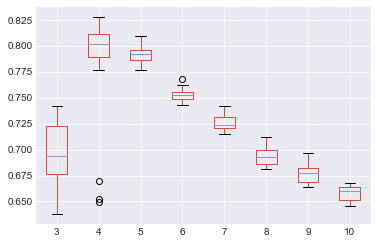

In [406]:
boxplot = ITCC_change_seed_4.boxplot(column=['3', '4', '5',"6","7","8","9","10"])
boxplot

In [396]:
ITCC_change_seed_4["3"].max() - ITCC_change_seed_4["3"].min()

0.10416580945578202

# Model Based Method

In [177]:
Model_based_results = pd.read_csv('vx_model_based_stemming.csv')

In [178]:
Model_based_results = pd.DataFrame(Model_based_results.drop(["X", "Unnamed: 0"], axis =1))

In [179]:
Model_based_results

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,4,3,0,1,2,4,3,10,10,13,13,2,16,14,16,14
1,0,0,3,3,3,5,7,4,3,5,10,13,10,2,15,14,12,14
2,0,3,1,2,3,1,7,8,4,2,4,0,0,3,0,10,14,19
3,2,0,3,0,0,7,0,4,10,3,9,7,4,6,7,12,12,2
4,0,3,3,3,3,5,2,8,3,10,9,1,0,14,10,6,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,1,2,2,4,1,4,1,0,9,1,12,2,1,15,6,8,4,17
12435,1,2,0,4,1,3,3,2,0,9,8,7,5,6,6,9,7,17
12436,1,2,2,4,1,4,1,0,1,4,12,2,1,11,4,8,4,17
12437,1,2,2,4,1,4,1,0,1,4,12,2,1,11,6,8,4,17


In [180]:
col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9", "r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]

In [181]:
Model_based_results.columns = col_name

In [182]:
Model_based_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,0,0,4,3,0,1,2,4,3,10,10,13,13,2,16,14,16,14
1,0,0,3,3,3,5,7,4,3,5,10,13,10,2,15,14,12,14
2,0,3,1,2,3,1,7,8,4,2,4,0,0,3,0,10,14,19
3,2,0,3,0,0,7,0,4,10,3,9,7,4,6,7,12,12,2
4,0,3,3,3,3,5,2,8,3,10,9,1,0,14,10,6,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,1,2,2,4,1,4,1,0,9,1,12,2,1,15,6,8,4,17
12435,1,2,0,4,1,3,3,2,0,9,8,7,5,6,6,9,7,17
12436,1,2,2,4,1,4,1,0,1,4,12,2,1,11,4,8,4,17
12437,1,2,2,4,1,4,1,0,1,4,12,2,1,11,6,8,4,17


In [183]:
#NMI
MB_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = Model_based_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    MB_NMI.append(NMI)

In [184]:
MB_NMI

[0.4583168832250383,
 0.43894692901679055,
 0.32544906740898605,
 0.5071878576929155,
 0.4932914184622104,
 0.4804506121271954,
 0.4920324671596314,
 0.4564451845392707,
 0.31403552312748895,
 0.43721453064723353,
 0.2921036758665151,
 0.2938806010419014,
 0.29923148302506447,
 0.2875372233726535,
 0.26421060209766467,
 0.2839412072733192,
 0.4485616622000316,
 0.2760085149532954]

In [185]:
# Purity
MB_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(Model_based_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12425
    MB_purity.append(purity)
MB_purity

[0.618430583501006,
 0.6385513078470825,
 0.5696579476861167,
 0.7368209255533199,
 0.7760160965794769,
 0.7575050301810865,
 0.7752112676056339,
 0.77158953722334,
 0.6340442655935614,
 0.7577464788732394,
 0.6029778672032193,
 0.5941247484909457,
 0.6202816901408451,
 0.6163380281690141,
 0.5650704225352112,
 0.6001609657947686,
 0.7685311871227364,
 0.5958953722334004]

# BBAC

In [32]:
BBAC_results = pd.read_csv('BBAC_results_total_1.csv')

In [33]:
BBAC_results = pd.DataFrame(BBAC_results.drop(["Unnamed: 0", "screen_name", "user_id_new"], axis =1))

In [34]:
BBAC_results

,BBAC_results_3,BBAC_results_4,BBAC_results_5,BBAC_results_6,BBAC_results_7,BBAC_results_8,BBAC_results_9,BBAC_results_10,BBAC_results_11,BBAC_results_12,BBAC_results_13,BBAC_results_14,BBAC_results_15,BBAC_results_16,BBAC_results_17,BBAC_results_18,BBAC_results_19,BBAC_results_20
0,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,3
1,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,7
2,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,3
3,1,1,1,6,1,4,9,3,7,6,12,6,6,6,13,12,16,10
4,1,1,1,6,1,4,9,3,7,6,13,6,4,6,11,12,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12420,3,4,4,3,3,5,4,7,9,8,7,5,5,9,6,1,7,18
12421,1,4,3,3,5,6,6,2,5,1,1,3,9,2,12,7,13,18
12422,3,4,4,4,7,5,4,1,9,3,7,5,3,16,10,7,12,19
12423,3,4,3,3,5,6,6,2,1,3,1,12,10,16,6,7,7,18


In [35]:
col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9","r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]

In [36]:
BBAC_results.columns = col_name

In [37]:
BBAC_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,3
1,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,7
2,1,1,1,6,1,4,9,3,7,6,13,6,6,6,11,12,16,3
3,1,1,1,6,1,4,9,3,7,6,12,6,6,6,13,12,16,10
4,1,1,1,6,1,4,9,3,7,6,13,6,4,6,11,12,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12420,3,4,4,3,3,5,4,7,9,8,7,5,5,9,6,1,7,18
12421,1,4,3,3,5,6,6,2,5,1,1,3,9,2,12,7,13,18
12422,3,4,4,4,7,5,4,1,9,3,7,5,3,16,10,7,12,19
12423,3,4,3,3,5,6,6,2,1,3,1,12,10,16,6,7,7,18


In [38]:
#NMI
BBAC_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = BBAC_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    BBAC_NMI.append(NMI)

In [39]:
BBAC_NMI

[0.618735410253498,
 0.8146788513658716,
 0.7752120374993327,
 0.7361527116987905,
 0.7297859801733847,
 0.7032243565454707,
 0.6958342183409043,
 0.6753398878736551,
 0.6665908482145184,
 0.6456531503136532,
 0.6308206385850017,
 0.6249227699120012,
 0.618641626223736,
 0.6351732100253534,
 0.6035256255327003,
 0.594580919305854,
 0.5968091083224623,
 0.5805466271509863]

In [40]:
# Purity
BBAC_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(BBAC_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12425
    BBAC_purity.append(purity)
BBAC_purity

[0.7010060362173038,
 0.943420523138833,
 0.9467203219315895,
 0.9484909456740442,
 0.9530784708249497,
 0.9548490945674044,
 0.9553319919517103,
 0.9525150905432596,
 0.941327967806841,
 0.9409255533199196,
 0.9536418511066398,
 0.9457545271629779,
 0.9541247484909456,
 0.9543661971830986,
 0.9542857142857143,
 0.9541247484909456,
 0.9562173038229377,
 0.9561368209255533]

In [256]:
BBAC_results = pd.read_csv('BBAC_results_stemming.csv')
BBAC_results = pd.DataFrame(BBAC_results.drop(["Unnamed: 0", "x"], axis =1))

In [257]:
BBAC_results

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1,4,2,2,7,1,2,2,11,11,4,9,8,13,7,12,6,14
1,1,4,2,6,1,1,2,5,11,10,4,8,8,13,7,12,5,20
2,1,4,2,2,7,1,2,2,11,10,4,8,8,13,7,12,5,20
3,1,4,2,2,7,1,2,5,11,11,4,8,8,12,7,12,5,20
4,1,4,2,2,1,1,2,2,11,10,4,8,8,13,7,12,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,3,1,4,3,3,7,3,9,1,9,8,1,3,10,8,14,12,1
12435,3,1,4,5,4,4,9,6,4,5,1,10,15,9,10,6,14,13
12436,3,1,4,3,3,4,9,10,10,9,8,12,9,3,8,6,4,2
12437,3,1,4,3,4,4,9,10,7,3,8,12,9,10,10,6,13,7


In [258]:
col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9","r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]

In [260]:
BBAC_results.columns = col_name

In [261]:
BBAC_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,1,4,2,2,7,1,2,2,11,11,4,9,8,13,7,12,6,14
1,1,4,2,6,1,1,2,5,11,10,4,8,8,13,7,12,5,20
2,1,4,2,2,7,1,2,2,11,10,4,8,8,13,7,12,5,20
3,1,4,2,2,7,1,2,5,11,11,4,8,8,12,7,12,5,20
4,1,4,2,2,1,1,2,2,11,10,4,8,8,13,7,12,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,3,1,4,3,3,7,3,9,1,9,8,1,3,10,8,14,12,1
12435,3,1,4,5,4,4,9,6,4,5,1,10,15,9,10,6,14,13
12436,3,1,4,3,3,4,9,10,10,9,8,12,9,3,8,6,4,2
12437,3,1,4,3,4,4,9,10,7,3,8,12,9,10,10,6,13,7


In [262]:
#NMI
BBAC_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = BBAC_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    BBAC_NMI.append(NMI)

In [263]:
BBAC_NMI

[0.6681889307378849,
 0.5875640906477007,
 0.7707255737462888,
 0.5813804518269956,
 0.7276513790613726,
 0.6985922746544447,
 0.6816101509152742,
 0.6733123798733321,
 0.6533675579393954,
 0.6213844871725758,
 0.6443555541849032,
 0.6142967158313571,
 0.6080992445515759,
 0.5942206908557847,
 0.5857388692818499,
 0.5947840570958952,
 0.5736356374306866,
 0.5718474510009416]

In [264]:
# Purity
BBAC_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(BBAC_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12425
    BBAC_purity.append(purity)
BBAC_purity

[0.7392354124748491,
 0.7109859154929578,
 0.9480885311871228,
 0.7699798792756539,
 0.9576659959758551,
 0.9426156941649899,
 0.9489738430583501,
 0.9497786720321931,
 0.9480885311871228,
 0.9538028169014084,
 0.9584708249496982,
 0.9464788732394366,
 0.9447887323943662,
 0.9439034205231388,
 0.9416498993963782,
 0.9554124748490945,
 0.9495372233400402,
 0.9499396378269618]

# DCC

In [143]:
DCC_running = pd.read_csv('DCC_running_time_stemming.csv')
DCC_running = pd.DataFrame(DCC_running.drop(["Unnamed: 0"], axis =1))

In [152]:
DCC_running

,Running_Time
0,97.05
1,82.64
2,81.58
3,114.13
4,72.65
5,105.52
6,93.08
7,98.95
8,91.34
9,103.77


In [153]:
DCC_running["Running_Time"]

0      97.05
1      82.64
2      81.58
3     114.13
4      72.65
5     105.52
6      93.08
7      98.95
8      91.34
9     103.77
10     94.53
11     95.50
12    105.22
13     95.22
14     90.50
15     78.93
16     55.72
17     56.97
Name: Running_Time, dtype: float64

In [259]:
#DCC_results = pd.read_csv('DCC_results_total.csv')
#DCC_results = pd.read_csv('DCC_results_total_new_stemming.csv')
DCC_results = pd.read_csv('DCC_results_total_new_lemmatization.csv')

In [260]:
DCC_results = pd.DataFrame(DCC_results.drop(["Unnamed: 0"], axis =1))

In [261]:
DCC_results

,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20
0,2,3,4,3,7,6,1,8,7,10,7,12,11,11,14,11,6,14
1,2,3,4,3,7,5,4,9,7,6,4,14,14,7,11,3,15,1
2,2,3,4,3,7,6,4,8,7,6,7,14,14,13,11,5,6,14
3,2,3,4,3,7,5,4,8,7,10,4,7,14,7,11,11,1,14
4,2,3,4,3,7,5,4,8,5,6,4,14,14,7,11,18,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12418,3,2,3,5,6,1,9,1,8,1,12,8,8,4,4,12,14,3
12419,3,3,4,5,5,4,5,5,9,10,5,13,5,9,9,16,17,16
12420,3,2,3,6,6,4,5,1,9,9,12,8,15,4,16,12,8,3
12421,3,2,3,6,5,4,5,2,9,5,13,11,6,4,17,4,8,13


In [262]:
col_name = ["r3", "r4", "r5", "r6","r7", "r8","r9", "r10", "r11", "r12", "r13","r14", "r15","r16", "r17","r18", "r19","r20"]

In [263]:
#NMI
DCC_NMI = []
for i, j in enumerate(col_name):
    num_cluster = i+3
    n = DCC_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    DCC_NMI.append(NMI)

In [264]:
DCC_NMI

[0.6199827258750429,
 0.8199319480515692,
 0.7306102277702825,
 0.6750136306572309,
 0.6432922659920977,
 0.6480011802414597,
 0.6035094821852536,
 0.5855152345283697,
 0.56808618217611,
 0.556654683923244,
 0.5220795207659271,
 0.5175208391052768,
 0.5128767582354423,
 0.48019632571169674,
 0.4928483023496834,
 0.4671129349520599,
 0.4574228490991505,
 0.4653250406074772]

In [265]:
# Purity
DCC_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(DCC_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12423
    DCC_purity.append(purity)
DCC_purity

[0.7342831844160026,
 0.9473557111808741,
 0.9224019962971907,
 0.9160428237945746,
 0.9210335667713113,
 0.9410770345327215,
 0.9133864605972792,
 0.9195041455365048,
 0.9121790227803268,
 0.9198261289543589,
 0.8860983659341544,
 0.9049343958786122,
 0.8989777026483136,
 0.8631570474120582,
 0.8988972067938501,
 0.8709651452950173,
 0.8817515897931256,
 0.8738629960557032]

# Robyn's method

In [479]:
Robyn_running = [0.019443499999397318, 3.5200000638724305e-05, 1.1399999493733048e-05, 9.500001397100277e-06,9.800000043469481e-06]

In [480]:
Robyn_running

[0.019443499999397318,
 3.5200000638724305e-05,
 1.1399999493733048e-05,
 9.500001397100277e-06,
 9.800000043469481e-06]

In [274]:
#Robyn_results = pd.read_csv('Robyn_results_my_preprocessing.csv')
#Robyn_results = pd.read_csv('Robyn_results_new_stemming.csv')
Robyn_results = pd.read_csv('Robyn_results_new_lemmatization.csv')

In [275]:
Robyn_results = pd.DataFrame(Robyn_results.drop(["Unnamed: 0"], axis =1))

In [276]:
Robyn_results

,NMI,Purity
0,0.614633,0.721565
1,0.603037,0.721565
2,0.642289,0.857039
3,0.696475,0.904210
4,0.694088,0.904210
5,0.664338,0.886259
6,0.691189,0.911294
7,0.688662,0.910891
8,0.740111,0.939387
9,0.582399,0.853981


In [277]:
Robyn_results["NMI"].tolist()

[0.6146330425805493,
 0.6030370464141879,
 0.6422888911934047,
 0.696475128177,
 0.6940880812746512,
 0.6643379164409532,
 0.6911893626871236,
 0.6886622499609251,
 0.7401111572930451,
 0.5823990185547027,
 0.5809062572660638,
 0.5745013316401074,
 0.5743807255734331,
 0.549864483104734,
 0.5341316634180167,
 0.5888066218517514,
 0.6055197521637046,
 0.6053889760106899]

# Monocle3

In [661]:
Monocle3_results = pd.read_csv('NMI_monocle3.csv')

In [662]:
Monocle3_results = pd.DataFrame(Monocle3_results.drop(["Unnamed: 0"], axis =1))

In [663]:
Monocle3_results

,5,6,7,8,9,10,11,12,13,14,...,140,160,180,200,220,240,260,280,300,320
0,25,21,21,17,14,10,7,9,6,7,...,1,1,1,1,1,1,1,1,1,1
1,9,8,4,5,6,6,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
2,9,11,4,5,6,6,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
3,9,8,4,5,6,6,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
4,30,11,4,5,6,6,11,5,5,5,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,24,15,3,3,4,4,1,1,1,2,...,2,2,2,2,2,1,1,1,1,1
12435,22,12,11,11,10,13,10,10,9,10,...,2,2,2,2,2,1,1,1,1,1
12436,2,4,3,3,4,4,1,1,1,2,...,2,2,2,2,2,1,1,1,1,1
12437,4,5,6,6,7,7,1,1,1,2,...,2,2,2,2,2,1,1,1,1,1


In [664]:
K = Monocle3_results.columns

In [665]:
K = list(map(int,K))

In [666]:
K

[5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 110,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320]

In [667]:
col_name = ["k5", "k6", "k7", "k8","k9", "k10","k11", "k12", "k13", "k14", "k15","k16", "k17","k18", "k19","k20", "k30","k35", "k40", "k45","k50","k55","k60","k65","k70","k75","k80","k85","k90","k95","k100","k110","k120","k140","k160","k180","k200","k220","k240","k260","k280","k300","k320"]

In [668]:
len(col_name)

43

In [669]:
len(col_name)
Monocle3_results.columns = col_name

In [670]:
#NMI
Monocle_NMI = []
for i, j in enumerate(col_name):
    n = Monocle3_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    Monocle_NMI.append(NMI)

In [671]:
Monocle_NMI

[0.43710715089831775,
 0.45829698527447127,
 0.47394126057358854,
 0.4897627285238365,
 0.5050653546635,
 0.5146697305799993,
 0.5325724093653281,
 0.5322384060462164,
 0.5442002419438011,
 0.5482972934334851,
 0.5572211571597532,
 0.5854905020281096,
 0.5934205326885754,
 0.6056897319804225,
 0.5968537112590946,
 0.628415737708886,
 0.6555820771170239,
 0.6590508044435192,
 0.672646302862962,
 0.6882368079999113,
 0.708171571236394,
 0.7234267232920484,
 0.725277493784622,
 0.7277885150622994,
 0.6616563272226438,
 0.6643597546510074,
 0.6643597546510074,
 0.6763658046240363,
 0.6763658046240363,
 0.6763658046240363,
 0.6763658046240363,
 0.693088407716485,
 0.6932919006351971,
 0.6932919006351971,
 0.693088407716485,
 0.693088407716485,
 0.693088407716485,
 0.693088407716485,
 0.5017667518912241,
 0.5017667518912241,
 0.5017667518912241,
 1.8426331247360293e-15,
 1.8426331247360293e-15]

In [672]:
max_index = Monocle_NMI.index(max(Monocle_NMI))
K[max_index]

65

In [673]:
max_index

23

In [674]:
NMI_data = {'K': K,
        'Monocle3_NMI': Monocle_NMI
        }
evaluation_summary_NMI = pd.DataFrame (NMI_data)

In [676]:
evaluation_summary_NMI

,K,Monocle3_NMI
0,5,4.371072e-01
1,6,4.582970e-01
2,7,4.739413e-01
3,8,4.897627e-01
4,9,5.050654e-01
5,10,5.146697e-01
6,11,5.325724e-01
7,12,5.322384e-01
8,13,5.442002e-01
9,14,5.482973e-01


In [677]:
#evaluation_summary_NMI.to_csv('evaluation_summary_NMI_monocle3.csv')

In [589]:
# Purity
Monocle_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(Monocle3_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12439
    Monocle_purity.append(purity)
Monocle_purity

[0.9448508722566122,
 0.9453332261435806,
 0.9448508722566122,
 0.9448508722566122,
 0.9442077337406544,
 0.9442077337406544,
 0.9484685264088754,
 0.9308626095345285,
 0.9442077337406544,
 0.9311841787925075,
 0.9233057319720235,
 0.9224214165125814,
 0.9291743709301391,
 0.9224214165125814,
 0.9291743709301391,
 0.9291743709301391,
 0.9387410563550125,
 0.9387410563550125,
 0.9388214486695072,
 0.9387410563550125,
 0.9345606560012862,
 0.9345606560012862,
 0.9344802636867915,
 0.9307822172200337,
 0.7545622638475762,
 0.7505426481228394,
 0.7505426481228394,
 0.7339818313369242,
 0.7339818313369242,
 0.7339818313369242,
 0.7339818313369242,
 0.7249778921135139,
 0.7250582844280087,
 0.7250582844280087,
 0.7249778921135139,
 0.7249778921135139,
 0.7249778921135139,
 0.7249778921135139,
 0.49794999598038425,
 0.49794999598038425,
 0.49794999598038425,
 0.2565318755526972,
 0.2565318755526972]

In [590]:
NMI_data = {'K': K,
        'Monocle3_NMI': Monocle_purity
        }
evaluation_summary_purity = pd.DataFrame (NMI_data)

In [591]:
df_new = Monocle3_results
df_new["tokenize"] = data_lemmatized2

In [592]:
set(df_new["65"])

KeyError: '65'

#Cluster 1
a_1 = list(df_new[df_new["65"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(10)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 2
a_2 = list(df_new[df_new["65"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(10)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 3
a_3 = list(df_new[df_new["65"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(10)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

#Cluster 4
a_4 = list(df_new[df_new["65"] == 4]["tokenize"])
b_4 = list(itertools.chain.from_iterable(a_4))

Cluster_4 = []
c_4 = Counter(b_4).most_common(10)
for i,j in enumerate(c_4):
    Cluster_4.append(j[0])
print(Cluster_4)

#Cluster 5
a_5 = list(df_new[df_new["65"] == 5]["tokenize"])
b_5 = list(itertools.chain.from_iterable(a_5))

Cluster_5 = []
c_5 = Counter(b_5).most_common(10)
for i,j in enumerate(c_5):
    Cluster_5.append(j[0])
print(Cluster_5)

data = {
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        'Cluster_4': Cluster_4,
        'Cluster_5': Cluster_5
        }
df = pd.DataFrame (data)

df

# Summary

In [171]:
evaluation_summary_NMI = pd.read_csv('evaluation_summary_NMI.csv')

In [172]:
evaluation_summary_NMI = evaluation_summary_NMI.drop(['Unnamed: 0'], axis = 1) 
#evaluation_summary_NMI["BBAC"] = BBAC_NMI
#evaluation_summary_NMI["DCC"] = DCC_NMI
evaluation_summary_NMI["Robyn's Method"] = Robyn_results["NMI"].tolist()

In [173]:
evaluation_summary_NMI

,K,LDA,Spectral_rand,Spectral_arpack,ITCC,Model_Based,BBAC,DCC,Robyn's Method
0,3,0.730009,0.712312,0.484854,0.706468,0.203380,0.618735,0.618255,0.614275
1,4,0.785991,0.699532,0.468633,0.657310,0.522864,0.814679,0.810432,0.602837
2,5,0.644859,0.791337,0.660885,0.790230,0.567406,0.775212,0.731496,0.687237
3,6,0.639504,0.775783,0.644879,0.761950,0.397313,0.736153,0.671254,0.662511
4,7,0.566725,0.734414,0.626986,0.720542,0.431833,0.729786,0.643989,0.660290
5,8,0.504828,0.714627,0.605425,0.686114,0.668911,0.703224,0.641826,0.661014
6,9,0.577669,0.722273,0.692248,0.663086,0.668189,0.695834,0.600869,0.682196
7,10,0.474616,0.716470,0.680460,0.673714,0.665404,0.675340,0.601083,0.691788
8,11,0.521984,0.683889,0.667491,0.650036,0.644955,0.666591,0.546120,0.716839
9,12,0.576241,0.676146,0.647087,0.628107,0.649018,0.645653,0.540882,0.587267


In [174]:
#len(list(range(3, 21)))
#len(list(LDA_NMI))

# CIDR

In [704]:
CIDR_results = pd.read_csv("CIDR_cluster_results.csv")

In [705]:
CIDR_results = pd.DataFrame(CIDR_results.drop(["Unnamed: 0"], axis =1))

In [706]:
CIDR_results

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12435,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12436,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12437,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [707]:
K = CIDR_results.columns
K = list(map(int,K))

In [708]:
col_name =  CIDR_results.columns
col_name

Index(['3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20'],
      dtype='object')

In [709]:
CIDR_results["20"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [710]:
#NMI
CIDR_NMI = []
for i, j in enumerate(col_name):
    n = CIDR_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    CIDR_NMI.append(NMI)

CIDR_NMI

[0.0763578770924233,
 0.12454465497307653,
 0.12955983048733363,
 0.1757337524791305,
 0.21216125605041644,
 0.20987636969960427,
 0.2075938163548,
 0.20533647269690572,
 0.20306970384740505,
 0.2027643364670783,
 0.20209983188867772,
 0.20615841076061941,
 0.21148468508538623,
 0.23217485530889312,
 0.23184278194805127,
 0.23144093109374794,
 0.2830059151659729,
 0.28282769151250126]

In [711]:
NMI_data = {'K': K,
        'CIDR_NMI': CIDR_NMI
        }
evaluation_summary_NMI = pd.DataFrame (NMI_data)
evaluation_summary_NMI

,K,CIDR_NMI
0,3,0.076358
1,4,0.124545
2,5,0.129560
3,6,0.175734
4,7,0.212161
5,8,0.209876
6,9,0.207594
7,10,0.205336
8,11,0.203070
9,12,0.202764


# Seurat

In [678]:
Seurat3_results = pd.read_csv('NMI_Seurat3.csv')

In [679]:
Seurat3_results = pd.DataFrame(Seurat3_results.drop(["Unnamed: 0"], axis =1))

In [680]:
max(Seurat3_results["800"])

1

In [681]:
K = Seurat3_results.columns
K = list(map(int,K))

In [682]:
col_name =  Seurat3_results.columns
col_name

Index(['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '30', '35', '40', '45', '50', '55', '60', '65', '70',
       '75', '80', '85', '90', '95', '100', '110', '120', '130', '150', '170',
       '200', '300', '500', '700', '800', '1000', '1200', '1400'],
      dtype='object')

In [714]:
len(True_Label)

12439

In [716]:
idx = range(1,12440)
len(idx)

12439

In [733]:
#True_Label = True_Label_matrix["True_Label"].tolist()

In [734]:
#type(True_Label)

list

In [728]:
True_Label_matrix = pd.DataFrame (True_Label)

In [730]:
True_Label_matrix

,idx,True_Label
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2
...,...,...
12434,12435,3
12435,12436,3
12436,12437,3
12437,12438,3


In [735]:
#True_Label_matrix.to_csv("True_Label_matrix.csv")

In [683]:
#NMI
Seurat3_NMI = []
for i, j in enumerate(col_name):
    n = Seurat3_results[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    Seurat3_NMI.append(NMI)

In [684]:
Seurat3_NMI

[0.49790932077671013,
 0.5275883524058719,
 0.5267108387162961,
 0.5350604840057078,
 0.476510925060591,
 0.4870941830683476,
 0.4909389544698542,
 0.49985376047516505,
 0.5111382073365673,
 0.5342202267974289,
 0.5236935455912745,
 0.5449617961172082,
 0.49468985673381977,
 0.5058795817694288,
 0.5200724801695267,
 0.5261279989337628,
 0.5579607031519201,
 0.5579937636674962,
 0.554357276217182,
 0.5563127333008221,
 0.5767961694162184,
 0.563376412719394,
 0.5602735062160225,
 0.5823400918053652,
 0.588397667392843,
 0.5924213086576712,
 0.6116361363320675,
 0.6060891233642371,
 0.6156086543689052,
 0.6161138226564096,
 0.6194405492503076,
 0.6223304074831763,
 0.6216043832986018,
 0.6380732871180339,
 0.6608251936255013,
 0.6751290991439136,
 0.6825374747985282,
 0.6978583590520829,
 0.5179909548310313,
 0.3415011063528649,
 1.8426331247360293e-15,
 1.8426331247360293e-15,
 1.8426331247360293e-15,
 1.8426331247360293e-15]

In [685]:
max_index = Seurat3_NMI.index(max(Seurat3_NMI))
K[max_index]

300

In [686]:
max_index

37

NMI_data = {'K': K,
        'Seurat_purity': Seurat3_NMI
        #'Monocle3_purity':[*Monocle_NMI, *non],
        }
evaluation_summary_NMI = pd.DataFrame (NMI_data)

In [687]:
NMI_data = {'K': K,
        'Seurat_NMI': Seurat3_NMI
        }
evaluation_summary_NMI = pd.DataFrame (NMI_data)
evaluation_summary_NMI

,K,Seurat_NMI
0,5,4.979093e-01
1,6,5.275884e-01
2,7,5.267108e-01
3,8,5.350605e-01
4,9,4.765109e-01
5,10,4.870942e-01
6,11,4.909390e-01
7,12,4.998538e-01
8,13,5.111382e-01
9,14,5.342202e-01


In [688]:
#evaluation_summary_NMI.to_csv('evaluation_summary_NMI_Seurat.csv')

In [628]:
# Purity
Seurat3_purity = []
for i, j in enumerate(col_name):
    n = pd.DataFrame(Seurat3_results[j])
    df_compare = pd.concat([n, Correct_target.reindex(df_doc_topic.index)], axis=1)
    nominator = df_compare.groupby([j, "user_id_new"], as_index=False)['screen_name'].count().sort_values('screen_name', ascending=False).drop_duplicates(j)["screen_name"].sum()
    purity = nominator/12439
    Seurat3_purity.append(purity)
Seurat3_purity

[0.9288528016721601,
 0.9336763405418442,
 0.9283704477851917,
 0.9302194710185706,
 0.9143017927486132,
 0.9248331859474235,
 0.9196076855052657,
 0.9166331698689605,
 0.9305410402765496,
 0.9220998472546025,
 0.93190770962296,
 0.9261998552938339,
 0.9220998472546025,
 0.9329528097113916,
 0.9307822172200337,
 0.9318273173084654,
 0.9281292708417075,
 0.9292547632446339,
 0.9318273173084654,
 0.9335155559128547,
 0.9344802636867915,
 0.9353645791462336,
 0.9356861484042126,
 0.9356861484042126,
 0.9326312404534126,
 0.9362488946056757,
 0.93496261757376,
 0.9338371251708336,
 0.931023394163518,
 0.9299782940750865,
 0.9264410322373181,
 0.9261998552938339,
 0.9264410322373181,
 0.9278880938982234,
 0.927405740011255,
 0.9269233861242865,
 0.929817509446097,
 0.9287724093576654,
 0.9213763164241499,
 0.9082723691615081,
 0.9085939384194871,
 0.8966958758742665,
 0.8923546908915507,
 0.9045743226947504,
 0.9065841305571187,
 0.700136666934641,
 0.6926601816866308,
 0.49577940348902644,

In [629]:
NMI_data = {'K': K,
        'Seurat_purity': Seurat3_purity
        #'Monocle3_purity':[*Monocle_purity, *non],
        }
evaluation_summary_purity = pd.DataFrame (NMI_data)

In [630]:
len([*Monocle_purity, *non])

52

In [631]:
print(len(Seurat3_purity))
len(Monocle_purity)

51


43

In [521]:
42-33

9

In [522]:
df_new = Seurat3_results
df_new["tokenize"] = data_lemmatized2

In [530]:

#Cluster 1
a_1 = list(df_new[df_new["800"] == 1]["tokenize"])
b_1 = list(itertools.chain.from_iterable(a_1))

Cluster_1 = []
c_1 = Counter(b_1).most_common(50)
for i,j in enumerate(c_1):
    Cluster_1.append(j[0])
print(Cluster_1)

#Cluster 2
a_2 = list(df_new[df_new["800"] == 2]["tokenize"])
b_2 = list(itertools.chain.from_iterable(a_2))

Cluster_2 = []
c_2 = Counter(b_2).most_common(50)
for i,j in enumerate(c_2):
    Cluster_2.append(j[0])
print(Cluster_2)

#Cluster 3
a_3 = list(df_new[df_new["800"] == 3]["tokenize"])
b_3 = list(itertools.chain.from_iterable(a_3))

Cluster_3 = []
c_3 = Counter(b_3).most_common(50)
for i,j in enumerate(c_3):
    Cluster_3.append(j[0])
print(Cluster_3)

#Cluster 4
a_4 = list(df_new[df_new["800"] == 4]["tokenize"])
b_4 = list(itertools.chain.from_iterable(a_4))

Cluster_4 = []
c_4 = Counter(b_4).most_common(50)
for i,j in enumerate(c_4):
    Cluster_4.append(j[0])
print(Cluster_4)

#Cluster 5
#a_5 = list(df_new[df_new["800"] == 5]["tokenize"])
#b_5 = list(itertools.chain.from_iterable(a_5))

#Cluster_5 = []
#c_5 = Counter(b_5).most_common(50)
#for i,j in enumerate(c_5):
   # Cluster_5.append(j[0])
#print(Cluster_5)


['health', 'care', 'ppfa', 'plan', 'peopl', 'parenthood', 'abort', 'get', 'women', 'thank', 'right', 'make', 'access', 'control', 'need', 'birth', 'today', 'sexual', 'sex', 'help', 'us', 'live', 'chelsea', 'reproduct', 'day', 'center', 'via', 'take', 'patient', 'like', 'provid', 'one', 'fight', 'support', 'use', 'work', 'year', 'know', 'famili', 'time', 'learn', 'safe', 'stand', 'commun', 'istandwithpp', 'educ', 'deserv', 'call', 'senat', 'best']
['vegan', 'recip', 'tofu', 'chocol', 'made', 'easi', 'bean', 'potato', 'salad', 'comment', 'sauc', 'make', 'soup', 'chickpea', 'mushroom', 'free', 'rice', 'sweet', 'roast', 'pasta', 'homemad', 'bake', 'cake', 'fri', 'curri', 'delici', 'chees', 'lentil', 'tomato', 'black', 'cauliflow', 'bowl', 'creami', 'coconut', 'peanut', 'garlic', 'banana', 'veggi', 'gluten', 'red', 'cooki', 'butter', 'pumpkin', 'pie', 'cream', 'spici', 'green', 'avocado', 'link', 'pizza']
['storm', 'week', 'across', 'tropic', 'wind', 'rain', 'state', 'weather', 'unit', 'flo

In [532]:
data = {
        'Cluster_1': Cluster_1,
        'Cluster_2': Cluster_2,
        'Cluster_3': Cluster_3,
        'Cluster_4': Cluster_4
       # 'Cluster_5': Cluster_5
        }
df = pd.DataFrame (data)

df

,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,health,vegan,storm,goblu
1,care,recip,week,michigan
2,ppfa,tofu,across,umichfootbal
3,plan,chocol,tropic,game
4,peopl,made,wind,problu
5,parenthood,easi,rain,big
6,abort,bean,state,day
7,get,potato,weather,play
8,women,salad,unit,wolverin
9,thank,comment,flood,week


# PC and Num of clusters

In [738]:
Monocle3_PC_NumCluster_corresp = pd.read_csv('Monocle3_PC_NumCluster_corresp.csv')

In [740]:
Monocle3_PC_NumCluster_corresp = pd.DataFrame(Monocle3_PC_NumCluster_corresp.drop(["Unnamed: 0"], axis =1))

In [741]:
Monocle3_PC_NumCluster_corresp

,PC_40_20,PC_40_18,PC_40_15,PC_40_14,PC_40_12,PC_40_10,PC_40_8,PC_40_6,PC_40_4,PC_40_2,...,PC_4_20,PC_4_18,PC_4_15,PC_4_14,PC_4_12,PC_4_10,PC_4_8,PC_4_6,PC_4_4,PC_4_2
0,4,4,4,4,4,4,4,4,1,1,...,1,1,1,1,1,1,1,1,1,1
1,4,4,4,4,4,4,4,4,1,1,...,1,1,1,1,1,1,1,1,1,1
2,4,4,4,4,4,4,4,4,1,1,...,1,1,1,1,1,1,1,1,1,1
3,4,4,4,4,4,4,4,4,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,4,4,4,4,4,4,4,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12434,2,2,2,2,2,2,2,2,3,2,...,2,3,2,3,2,2,2,2,2,2
12435,2,2,2,2,2,2,2,2,3,2,...,2,3,2,3,2,2,2,2,2,2
12436,2,2,2,2,2,2,2,2,3,2,...,2,3,2,3,2,2,2,2,2,2
12437,2,2,2,2,2,2,2,2,3,2,...,2,3,2,3,2,2,2,2,2,2


In [742]:
col_name =  Monocle3_PC_NumCluster_corresp.columns

In [743]:
#NMI
PC_NMI = []
for i, j in enumerate(col_name):
    n = Monocle3_PC_NumCluster_corresp[j]
    NMI = normalized_mutual_info_score(True_Label, n)
    PC_NMI.append(NMI)

In [746]:
len(PC_NMI)

100

In [747]:
PC_NMI_matrix = {
        'PC_NMI': PC_NMI
        }
PC_NMI_matrix = pd.DataFrame (PC_NMI_matrix)
PC_NMI_matrix

,PC_NMI
0,0.753747
1,0.751819
2,0.751819
3,0.751819
4,0.757826
...,...
95,0.649615
96,0.648773
97,0.654996
98,0.432180


In [749]:
PC_NMI_matrix.to_csv("PC_NMI_matrix.csv")

# Running

In [174]:
import matplotlib.pyplot as plt

In [370]:
BBAC_Running = pd.read_csv("BBAC_running_time_stemming.csv")

In [371]:
BBAC_Running

,Unnamed: 0,Running_Time
0,1,2305.89
1,2,7719.47
2,3,6113.25
3,4,8437.46
4,5,6946.16
5,6,27550.56
6,7,18734.56
7,8,18565.57
8,9,7466.31
9,10,30089.74


In [268]:
Running_time_comparison = {
    "K": [3,4,5,6,7],
    "LDA": LDA_running,
    "ITCC": ITCC_Running,
    "DCC": DCC_Running,
    "Robyn's Method": Robyn_running,
    "BBAC" : BBAC_Running["Running_time"]
}

NameError: name 'DCC_Running' is not defined

In [549]:
Running_time_comparison = pd.DataFrame (Running_time_comparison)

In [537]:
Running_time_comparison

,K,LDA,ITCC,DCC,Robyn's Method,BBAC
0,3,26.187462,9.695329,34.33,0.019443,3306.46
1,4,23.118970,10.194038,29.95,0.000035,11320.96
2,5,22.364821,9.626166,31.88,0.000011,8874.86
3,6,22.977040,17.134551,30.28,0.000010,8720.80
4,7,23.449289,10.220091,33.34,0.000010,12389.30


In [540]:
#Running_time_comparison.to_csv('Running_time_comparison.csv')

In [358]:
Running_Time_summary

,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based,BACC
0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50,0.668189
1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75,0.587564
2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03,0.770726
3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66,0.581380
4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55,0.727651
5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83,0.698592
6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36,0.681610
7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65,0.673312
8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20,0.653368
9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43,0.621384


In [377]:
#RB_running = pd.read_csv("Robyn_running_stemming_new.csv")

In [360]:
#RB_running

,Unnamed: 0,0
0,0,45.102625
1,1,43.275857
2,2,43.079089
3,3,47.190553
4,4,47.457919
5,5,46.055747
6,6,45.301097
7,7,48.507143
8,8,44.973521
9,9,44.569450


In [364]:
#Running_Time_summary["Robyn Method"] = RB_running["0"]

In [372]:
Running_Time_summary

,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based,BACC,Robyn Method
0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50,0.668189,45.102625
1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75,0.587564,43.275857
2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03,0.770726,43.079089
3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66,0.581380,47.190553
4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55,0.727651,47.457919
5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83,0.698592,46.055747
6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36,0.681610,45.301097
7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65,0.673312,48.507143
8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20,0.653368,44.973521
9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43,0.621384,44.569450


In [374]:
#Running_Time_summary["BBAC"] = BBAC_Running["Running_Time"]

In [375]:
Running_Time_summary 

,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based,BACC,Robyn Method,BBAC
0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50,0.668189,45.102625,2305.89
1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75,0.587564,43.275857,7719.47
2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03,0.770726,43.079089,6113.25
3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66,0.581380,47.190553,8437.46
4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55,0.727651,47.457919,6946.16
5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83,0.698592,46.055747,27550.56
6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36,0.681610,45.301097,18734.56
7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65,0.673312,48.507143,18565.57
8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20,0.653368,44.973521,7466.31
9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43,0.621384,44.569450,30089.74


In [382]:
Running_Time_summary.to_csv("Running_Time_summary_stemming_new_final.csv")

In [383]:
Running_Time_summary =  pd.read_csv("Running_Time_summary_stemming_new_final.csv")

In [384]:
Running_Time_summary

,Unnamed: 0,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based,Robyn Method,BBAC
0,0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50,45.102625,2305.89
1,1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75,43.275857,7719.47
2,2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03,43.079089,6113.25
3,3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66,47.190553,8437.46
4,4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55,47.457919,6946.16
5,5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83,46.055747,27550.56
6,6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36,45.301097,18734.56
7,7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65,48.507143,18565.57
8,8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20,44.973521,7466.31
9,9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43,44.569450,30089.74


In [380]:
#Running_Time_summary = pd.DataFrame(Running_Time_summary.drop(["Unnamed: 0", "BACC"], axis =1))

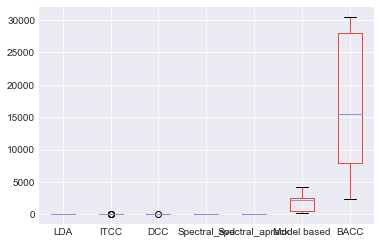

In [279]:
#boxplot
boxplot =Running_Time_summary.boxplot(column=['LDA', 'ITCC', 'DCC',"Spectral_svd","Spectral_aprack", "Model based", "BACC"])
boxplot

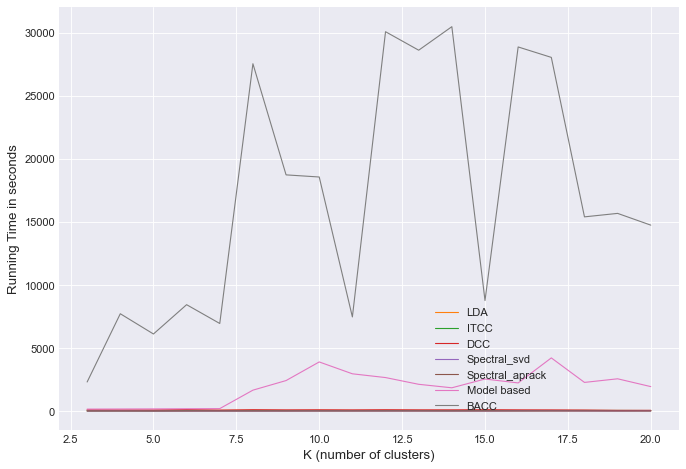

In [280]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')
 
# multiple line plot
#color_palette = ["red","blue","orange","green","purple"]
num = 0
for column in Running_Time_summary.drop('K', axis=1):
    #color_n = color_palette[num]
    num+=1
    plt.plot(Running_Time_summary['K'],  Running_Time_summary[column], marker='', color=palette(num), linewidth=1, alpha=1, label=column)
 # Add legend
    #plt.legend(loc=2, ncol=2)
    plt.legend(bbox_to_anchor=(0.6, 0.3), loc=2, borderaxespad=0.)
 # Add titles
    #plt.title("NMI for Seurat and Monocle3 Clustering", loc='left', fontsize=15, fontweight=0, color='black')
    plt.xlabel("K (number of clusters)")
    plt.ylabel("Running Time in seconds")



### (1) NMI

In [349]:
non = [None] * 9

In [363]:
len([*BBAC_NMI, *non])

18

In [278]:
NMI_data = {'K': list(range(3, 21)),
        'LDA': LDA_NMI,
        #'Spectral_rand': Spectral_NMI,
        #'Spectral_arpack': Spectral_NMI_1,
        'ITCC': ITCC_NMI,
        "DCC": DCC_NMI,
        #'Model_Based': MB_NMI,
        #"BBAC": [*BBAC_NMI, *non]
        "Robyn's Method": Robyn_results["NMI"].tolist()
        }
evaluation_summary_NMI = pd.DataFrame (NMI_data)

In [279]:
evaluation_summary_NMI

,K,LDA,ITCC,DCC,Robyn's Method
0,3,0.568610,0.681532,0.619983,0.614633
1,4,0.657514,0.787763,0.819932,0.603037
2,5,0.535833,0.785885,0.730610,0.642289
3,6,0.603660,0.753087,0.675014,0.696475
4,7,0.551582,0.725043,0.643292,0.694088
5,8,0.513401,0.704353,0.648001,0.664338
6,9,0.446498,0.681592,0.603509,0.691189
7,10,0.517224,0.651785,0.585515,0.688662
8,11,0.529029,0.640550,0.568086,0.740111
9,12,0.444906,0.617202,0.556655,0.582399


In [280]:
#evaluation_summary_NMI.to_csv('evaluation_summary_NMI_new_lemmatization.csv')

In [308]:
evaluation_summary_NMI.to_csv('evaluation_summary_NMI_new_stemming.csv')

In [309]:
evaluation_summary_NMI = pd.read_csv("evaluation_summary_NMI_new_stemming.csv")

In [310]:
evaluation_summary_NMI

,Unnamed: 0,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model Based,BBAC
0,0,3,0.739975,0.704310,0.618672,0.409773,0.714602,0.488511,0.458317,0.668189
1,1,4,0.830290,0.679012,0.826124,0.726670,0.699023,0.472867,0.438947,0.587564
2,2,5,0.773391,0.785782,0.734219,0.713720,0.795279,0.687319,0.325449,0.770726
3,3,6,0.677983,0.743139,0.674763,0.600645,0.776660,0.649464,0.507188,0.581380
4,4,7,0.578343,0.711141,0.632556,0.604515,0.737081,0.634199,0.493291,0.727651
5,5,8,0.480322,0.705873,0.635086,0.553537,0.721737,0.612179,0.480451,0.698592
6,6,9,0.538994,0.683587,0.617728,0.610422,0.718749,0.696230,0.492032,0.681610
7,7,10,0.520122,0.647890,0.581689,0.612004,0.689971,0.680501,0.456445,0.673312
8,8,11,0.475920,0.637693,0.564538,0.609637,0.685968,0.663776,0.314036,0.653368
9,9,12,0.514666,0.630689,0.549884,0.590844,0.679484,0.648163,0.437215,0.621384


evaluation_summary_NMI["Spectral_svd"] = Spectral_NMI
evaluation_summary_NMI["Spectral_aprack"] =Spectral_NMI_1

evaluation_summary_NMI["Model Based"] = MB_NMI

In [311]:
evaluation_summary_NMI

,Unnamed: 0,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model Based,BBAC
0,0,3,0.739975,0.704310,0.618672,0.409773,0.714602,0.488511,0.458317,0.668189
1,1,4,0.830290,0.679012,0.826124,0.726670,0.699023,0.472867,0.438947,0.587564
2,2,5,0.773391,0.785782,0.734219,0.713720,0.795279,0.687319,0.325449,0.770726
3,3,6,0.677983,0.743139,0.674763,0.600645,0.776660,0.649464,0.507188,0.581380
4,4,7,0.578343,0.711141,0.632556,0.604515,0.737081,0.634199,0.493291,0.727651
5,5,8,0.480322,0.705873,0.635086,0.553537,0.721737,0.612179,0.480451,0.698592
6,6,9,0.538994,0.683587,0.617728,0.610422,0.718749,0.696230,0.492032,0.681610
7,7,10,0.520122,0.647890,0.581689,0.612004,0.689971,0.680501,0.456445,0.673312
8,8,11,0.475920,0.637693,0.564538,0.609637,0.685968,0.663776,0.314036,0.653368
9,9,12,0.514666,0.630689,0.549884,0.590844,0.679484,0.648163,0.437215,0.621384


In [312]:
evaluation_summary_NMI = pd.DataFrame(evaluation_summary_NMI.drop(["Unnamed: 0"], axis =1))

In [313]:
evaluation_summary_NMI

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model Based,BBAC
0,3,0.739975,0.704310,0.618672,0.409773,0.714602,0.488511,0.458317,0.668189
1,4,0.830290,0.679012,0.826124,0.726670,0.699023,0.472867,0.438947,0.587564
2,5,0.773391,0.785782,0.734219,0.713720,0.795279,0.687319,0.325449,0.770726
3,6,0.677983,0.743139,0.674763,0.600645,0.776660,0.649464,0.507188,0.581380
4,7,0.578343,0.711141,0.632556,0.604515,0.737081,0.634199,0.493291,0.727651
5,8,0.480322,0.705873,0.635086,0.553537,0.721737,0.612179,0.480451,0.698592
6,9,0.538994,0.683587,0.617728,0.610422,0.718749,0.696230,0.492032,0.681610
7,10,0.520122,0.647890,0.581689,0.612004,0.689971,0.680501,0.456445,0.673312
8,11,0.475920,0.637693,0.564538,0.609637,0.685968,0.663776,0.314036,0.653368
9,12,0.514666,0.630689,0.549884,0.590844,0.679484,0.648163,0.437215,0.621384


In [301]:
#evaluation_summary_NMI["BBAC"] = BBAC_NMI

In [302]:
#evaluation_summary_NMI

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model Based,BACC,BBAC
0,3,0.739975,0.704310,0.618672,0.409773,0.714602,0.488511,0.458317,0.668189,0.668189
1,4,0.830290,0.679012,0.826124,0.726670,0.699023,0.472867,0.438947,0.587564,0.587564
2,5,0.773391,0.785782,0.734219,0.713720,0.795279,0.687319,0.325449,0.770726,0.770726
3,6,0.677983,0.743139,0.674763,0.600645,0.776660,0.649464,0.507188,0.581380,0.581380
4,7,0.578343,0.711141,0.632556,0.604515,0.737081,0.634199,0.493291,0.727651,0.727651
5,8,0.480322,0.705873,0.635086,0.553537,0.721737,0.612179,0.480451,0.698592,0.698592
6,9,0.538994,0.683587,0.617728,0.610422,0.718749,0.696230,0.492032,0.681610,0.681610
7,10,0.520122,0.647890,0.581689,0.612004,0.689971,0.680501,0.456445,0.673312,0.673312
8,11,0.475920,0.637693,0.564538,0.609637,0.685968,0.663776,0.314036,0.653368,0.653368
9,12,0.514666,0.630689,0.549884,0.590844,0.679484,0.648163,0.437215,0.621384,0.621384


# Running Time summary

In [198]:
MB_running = pd.read_csv('model_based_stemming_time.csv')

In [199]:
MB_running

,Unnamed: 0,MB_time
0,1,154.50
1,2,162.75
2,3,171.03
3,4,181.66
4,5,194.55
5,6,1657.83
6,7,2419.36
7,8,3895.65
8,9,2955.20
9,10,2656.43


In [201]:
Running_Time_summary = {'K': list(range(3, 21)),
        "LDA": LDA_running,
        "ITCC": ITCC_Running,
        "DCC": DCC_running["Running_Time"],
        "Spectral_svd" : Running_Time_spec_svd,
        "Spectral_aprack" : Running_Time_spec_Arpack,
        "Model based": MB_running["MB_time"]
        }
Running_Time_summary = pd.DataFrame (Running_Time_summary)

In [202]:
Running_Time_summary

,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based
0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50
1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75
2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03
3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66
4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55
5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83
6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36
7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65
8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20
9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43


In [142]:
Running_Time_summary

,K,LDA,ITCC,Spectral_svd,Spectral_aprack
0,3,54.071120,19.426828,5.682146,1.725138
1,4,52.866011,21.631384,8.390729,1.500349
2,5,47.397413,16.746600,1.534400,1.521714
3,6,49.986117,35.292282,1.362212,1.427517
4,7,51.848443,37.233680,1.436830,1.550656
5,8,57.296649,34.474125,1.243539,1.846353
6,9,43.567564,37.454208,1.306361,2.406472
7,10,53.075640,35.368386,8.502317,2.287773
8,11,45.953283,39.134652,6.806209,2.416388
9,12,50.085566,38.442115,8.090570,2.919354


In [203]:
#Running_Time_summary.to_csv('Running_Time_summary_new_stemming.csv')

In [204]:
Running_Time_summary = pd.read_csv('Running_Time_summary_new_stemming.csv')

In [205]:
Running_Time_summary = Running_Time_summary.drop(['Unnamed: 0'], axis = 1) 

In [206]:
Running_Time_summary

,K,LDA,ITCC,DCC,Spectral_svd,Spectral_aprack,Model based
0,3,54.071120,19.426828,97.05,5.682146,1.725138,154.50
1,4,52.866011,21.631384,82.64,8.390729,1.500349,162.75
2,5,47.397413,16.746600,81.58,1.534400,1.521714,171.03
3,6,49.986117,35.292282,114.13,1.362212,1.427517,181.66
4,7,51.848443,37.233680,72.65,1.436830,1.550656,194.55
5,8,57.296649,34.474125,105.52,1.243539,1.846353,1657.83
6,9,43.567564,37.454208,93.08,1.306361,2.406472,2419.36
7,10,53.075640,35.368386,98.95,8.502317,2.287773,3895.65
8,11,45.953283,39.134652,91.34,6.806209,2.416388,2955.20
9,12,50.085566,38.442115,103.77,8.090570,2.919354,2656.43


### (2) Purity

In [179]:
evaluation_summary_purity = pd.read_csv('evaluation_summary_purity.csv')

In [94]:
evaluation_summary_purity = evaluation_summary_purity.drop(['Unnamed: 0'], axis = 1) 
#evaluation_summary_purity["DCC"] = DCC_purity
evaluation_summary_purity["Robyn's method"] = Robyn_results["Purity"].tolist()
evaluation_summary_purity

KeyError: "['Unnamed: 0'] not found in axis"

In [281]:
purity_data = {'K': list(range(3, 21)),
        'LDA': LDA_purity,
        #'Spectral_rand': Spectral_purity,
        #'Spectral_arpack': Spectral_purity_1,
        'ITCC': ITCC_purity,
        "DCC": DCC_purity,
        #'Model_Based': MB_purity,
        #'BBAC': BBAC_purity
        "Robyn's Method": Robyn_results["Purity"].tolist()
        }
evaluation_summary_purity = pd.DataFrame (purity_data)

In [156]:
evaluation_summary_purity

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack
0,3,0.743549,0.737278,0.734223,0.652705,0.732636,0.502938
1,4,0.949031,0.837447,0.949353,0.895812,0.743581,0.505835
2,5,0.931425,0.945735,0.916151,0.893239,0.953481,0.876781
3,6,0.889943,0.930300,0.920251,0.842190,0.962414,0.854728
4,7,0.837929,0.954820,0.913739,0.859474,0.931831,0.856419
5,8,0.828845,0.956749,0.933033,0.838411,0.957586,0.856901
6,9,0.850068,0.942278,0.931265,0.876357,0.956781,0.954447
7,10,0.845325,0.936972,0.910765,0.887290,0.925634,0.958712
8,11,0.819841,0.941474,0.908996,0.873623,0.926197,0.961288
9,12,0.868559,0.958276,0.909237,0.873543,0.928934,0.961771


In [284]:
#evaluation_summary_purity.to_csv('evaluation_summary_purity_new_lemmatization.csv')

In [296]:
evaluation_summary_purity.to_csv('evaluation_summary_purity_new_stemming.csv')

In [297]:
evaluation_summary_purity = pd.read_csv("evaluation_summary_purity_new_stemming.csv")

In [298]:
#evaluation_summary_purity["Spectral_svd"] = Spectral_purity
#evaluation_summary_purity["Spectral_aprack"] = Spectral_purity_1

In [299]:
#evaluation_summary_purity["Model based"] = MB_purity

In [300]:
evaluation_summary_purity = pd.DataFrame(evaluation_summary_purity.drop(["Unnamed: 0"], axis =1))
evaluation_summary_purity

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model based,BBAC
0,3,0.743549,0.737278,0.734223,0.652705,0.732636,0.502938,0.618431,0.739235
1,4,0.949031,0.837447,0.949353,0.895812,0.743581,0.505835,0.638551,0.710986
2,5,0.931425,0.945735,0.916151,0.893239,0.953481,0.876781,0.569658,0.948089
3,6,0.889943,0.930300,0.920251,0.842190,0.962414,0.854728,0.736821,0.769980
4,7,0.837929,0.954820,0.913739,0.859474,0.931831,0.856419,0.776016,0.957666
5,8,0.828845,0.956749,0.933033,0.838411,0.957586,0.856901,0.757505,0.942616
6,9,0.850068,0.942278,0.931265,0.876357,0.956781,0.954447,0.775211,0.948974
7,10,0.845325,0.936972,0.910765,0.887290,0.925634,0.958712,0.771590,0.949779
8,11,0.819841,0.941474,0.908996,0.873623,0.926197,0.961288,0.634044,0.948089
9,12,0.868559,0.958276,0.909237,0.873543,0.928934,0.961771,0.757746,0.953803


In [293]:
evaluation_summary_purity

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model based
0,3,0.743549,0.737278,0.734223,0.652705,0.732636,0.502938,0.618431
1,4,0.949031,0.837447,0.949353,0.895812,0.743581,0.505835,0.638551
2,5,0.931425,0.945735,0.916151,0.893239,0.953481,0.876781,0.569658
3,6,0.889943,0.930300,0.920251,0.842190,0.962414,0.854728,0.736821
4,7,0.837929,0.954820,0.913739,0.859474,0.931831,0.856419,0.776016
5,8,0.828845,0.956749,0.933033,0.838411,0.957586,0.856901,0.757505
6,9,0.850068,0.942278,0.931265,0.876357,0.956781,0.954447,0.775211
7,10,0.845325,0.936972,0.910765,0.887290,0.925634,0.958712,0.771590
8,11,0.819841,0.941474,0.908996,0.873623,0.926197,0.961288,0.634044
9,12,0.868559,0.958276,0.909237,0.873543,0.928934,0.961771,0.757746


In [294]:
evaluation_summary_purity["BBAC"] = BBAC_purity

In [295]:
evaluation_summary_purity

,K,LDA,ITCC,DCC,Robyn's Method,Spectral_svd,Spectral_aprack,Model based,BBAC
0,3,0.743549,0.737278,0.734223,0.652705,0.732636,0.502938,0.618431,0.739235
1,4,0.949031,0.837447,0.949353,0.895812,0.743581,0.505835,0.638551,0.710986
2,5,0.931425,0.945735,0.916151,0.893239,0.953481,0.876781,0.569658,0.948089
3,6,0.889943,0.930300,0.920251,0.842190,0.962414,0.854728,0.736821,0.769980
4,7,0.837929,0.954820,0.913739,0.859474,0.931831,0.856419,0.776016,0.957666
5,8,0.828845,0.956749,0.933033,0.838411,0.957586,0.856901,0.757505,0.942616
6,9,0.850068,0.942278,0.931265,0.876357,0.956781,0.954447,0.775211,0.948974
7,10,0.845325,0.936972,0.910765,0.887290,0.925634,0.958712,0.771590,0.949779
8,11,0.819841,0.941474,0.908996,0.873623,0.926197,0.961288,0.634044,0.948089
9,12,0.868559,0.958276,0.909237,0.873543,0.928934,0.961771,0.757746,0.953803


### Visualization

### (1) NMI

In [314]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [315]:
from matplotlib.pyplot import figure

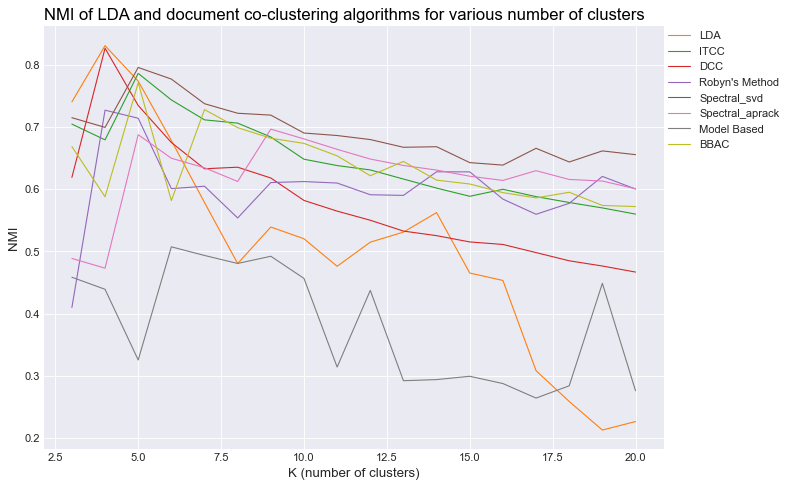

In [321]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')
 
# multiple line plot
#color_palette = ["red","blue","orange","green","purple"]
num = 0
for column in evaluation_summary_NMI.drop('K', axis=1):
    #color_n = color_palette[num]
    num+=1
    plt.plot(evaluation_summary_NMI['K'], evaluation_summary_NMI[column], marker='', color=palette(num), linewidth=1, alpha=1, label=column)
 # Add legend
    plt.legend(loc=2, ncol=2)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
 # Add titles
    plt.title("NMI of LDA and document co-clustering algorithms for various number of clusters", loc='left', fontsize=15, fontweight=0, color='black')
    plt.xlabel("K (number of clusters)")
    plt.ylabel("NMI")


### (2) Purity

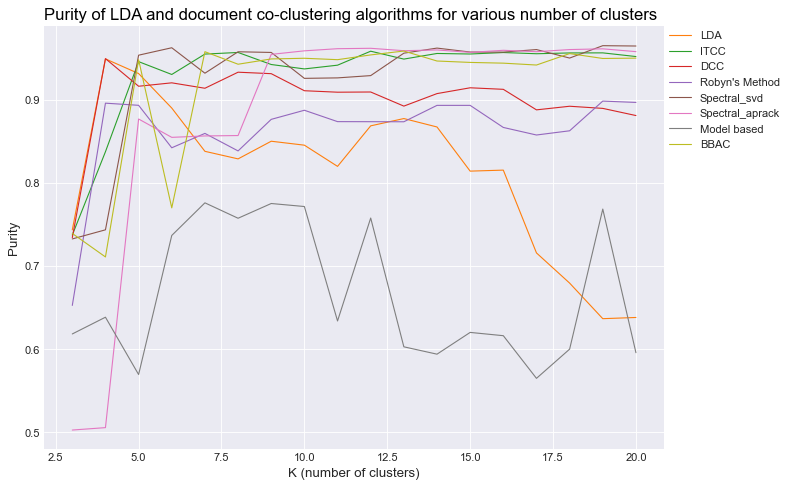

In [322]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')
 
# multiple line plot
#color_palette = ["red","blue","orange","green","purple"]
num = 0
for column in evaluation_summary_purity.drop('K', axis=1):
    #color_n = color_palette[num]
    num+=1
    plt.plot(evaluation_summary_purity['K'], evaluation_summary_purity[column], marker='', color=palette(num), linewidth=1, alpha=1, label=column)
 # Add legend
    plt.legend(loc=2, ncol=2)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
 # Add titles
    plt.title("Purity of LDA and document co-clustering algorithms for various number of clusters", loc='left', fontsize=15, fontweight=0, color='black')
    plt.xlabel("K (number of clusters)")
    plt.ylabel("Purity")


## Four_Cluster Performance Summary

In [190]:
Cluster4_evaluation_results = pd.read_csv('Cluster4_evaluation_results.csv')

In [191]:
Cluster4_evaluation_results

,Method,Purity,NMI,F_score
0,LDA,0.923058,0.785991,0.923775
1,Spectral_svd_rand,0.742133,0.699532,0.611991
2,ITCC,0.818913,0.657310,0.934615
3,Model-based methods(LBM),0.692475,0.522864,0.588929
4,BBAC,0.943421,0.814679,0.943626
5,DCC,0.943260,0.810432,0.943449
6,Robyn's method,0.721529,0.602837,NaN


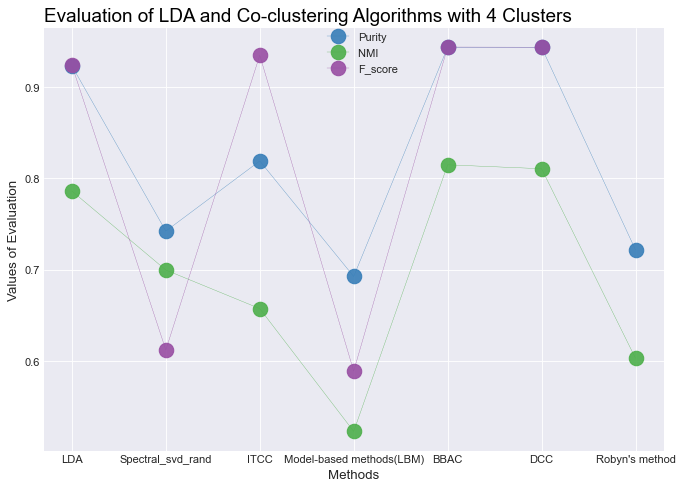

In [193]:
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in Cluster4_evaluation_results.drop('Method', axis=1):
    num+=1
    plt.plot(Cluster4_evaluation_results['Method'], Cluster4_evaluation_results[column], marker='o',linewidth=0.3,#linestyle='None',
             color=palette(num), alpha=0.9, label=column, markersize = 13.0)
 # Add legend
    plt.legend(bbox_to_anchor=(0.45, 1), loc=2, borderaxespad=0.)
 # Add titles
    plt.title("Evaluation of LDA and Co-clustering Algorithms with 4 Clusters", loc='left', fontsize=17, fontweight=0, color='black')
    plt.xlabel("Methods")
    plt.ylabel("Values of Evaluation")